# Temporal Digital Biomarkers for Alzheimer's Disease Detection

## A Multi-scale Behavioral Feature Analysis System

---

## Executive Summary

This notebook presents a novel **Temporal Digital Biomarker (TDB) system** for early Alzheimer's Disease (AD) detection using passive sensor data. Our approach extracts clinically-grounded behavioral features at multiple temporal scales and achieves **72% accuracy** in distinguishing cognitively normal (CN) from cognitively impaired (CI) individuals.

### Key Contributions:

1. **Six Temporal Behavioral Metrics** grounded in AD neuroscience
2. **Multi-scale Analysis** (1-hour, 6-hour, 15-hour windows)
3. **Transparent, Interpretable Scoring System** (vs black-box ML)
4. **Rigorous Train/Test Validation** (70/30 stratified split)
5. **Clinical Actionability** (adjustable weights for personalization)

### Performance:

- **Test Accuracy:** 72.0% (CN vs CI classification)
- **AUC-ROC:** 0.72
- **Sensitivity:** 85% (CI detection)
- **Specificity:** 62% (CN detection)

---

## Table of Contents

1. [Introduction & Background](#section1)
2. [Data & Preprocessing](#section2)
3. [Temporal Behavioral Metrics (6 Features)](#section3)
   - 3.1 Behavioral Diversity Index
   - 3.2 Temporal Regularity Score
   - 3.3 Perseveration Index
   - 3.4 Activity Pattern Consistency
   - 3.5 Daytime Energy Distribution
   - 3.6 Social Engagement Score
4. [Multi-scale Feature Extraction](#section4)
5. [Train/Test Split & CN Baseline](#section5)
6. [Classification & Evaluation](#section6)
7. [Results & Visualization](#section7)
8. [Discussion & Clinical Implications](#section8)

---

<a id='section1'></a>
## 1. Introduction & Background

### 1.1 Clinical Motivation

Alzheimer's Disease (AD) is characterized by progressive cognitive decline affecting multiple domains:

- **Executive Function:** Planning, decision-making, behavioral flexibility
- **Working Memory:** Temporal organization, time perception
- **Circadian Regulation:** Sleep-wake cycles, diurnal activity patterns
- **Social Cognition:** Apathy, social withdrawal

These cognitive impairments manifest as **observable behavioral changes** in daily life, which can be captured through passive monitoring.

---

### 1.2 Multi-scale Temporal Analysis

Different cognitive deficits emerge at different temporal scales:

```
┌─────────────────────────────────────────────────────────────┐
│ SHORT-TERM (1 hour)                                          │
│   - Immediate behavioral patterns                            │
│   - Cognitive flexibility                                    │
│   - Working memory capacity                                  │
└─────────────────────────────────────────────────────────────┘
                         ↓
┌─────────────────────────────────────────────────────────────┐
│ MID-TERM (6 hours)                                           │
│   - Daily routine structure                                  │
│   - Activity pattern consistency                             │
│   - Social engagement                                        │
└─────────────────────────────────────────────────────────────┘
                         ↓
┌─────────────────────────────────────────────────────────────┐
│ LONG-TERM (15 hours, daytime)                                │
│   - Circadian rhythm integrity                               │
│   - Energy distribution across day                           │
│   - Sundowning syndrome detection                            │
└─────────────────────────────────────────────────────────────┘
```

---

### 1.3 Dataset

- **Source:** Passive depth-camera monitoring in home environment
- **Population:** 68 subjects (25 CN, 20 MCI, 23 AD)
- **Data Type:** Timestamped action sequences (21 action categories)
- **Duration:** Multi-day continuous monitoring
- **Annotations:** Clinical diagnosis (CN/MCI/AD)

---

<a id='section2'></a>
## 2. Setup & Data Loading

In [1006]:
# Import libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from collections import Counter
from scipy import stats
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(['#3498DB', '#2ECC71', '#E74C3C'])  # Blue=CN, Green=MCI, Red=AD
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print("✓ Environment initialized")

✓ Environment initialized


In [1007]:
# Load subject metadata
with open('../sample_data/subjects.json', 'r') as f:
    subjects_meta = json.load(f)

# Create a dictionary: anon_id -> metadata
subject_dict = {s['anon_id']: s for s in subjects_meta}

# Load sequence data from JSONL
from collections import defaultdict
sequences = []
with open('../sample_data/sequences.jsonl', 'r') as f:
    for line in f:
        sequences.append(json.loads(line))

# Merge sequences by subject (aggregate all months per subject)
subject_sequences = defaultdict(list)
for seq_record in sequences:
    anon_id = seq_record['anon_id']
    subject_sequences[anon_id].extend(seq_record['sequence'])

# Reconstruct subjects list with complete data
subjects_raw = []
for anon_id, full_sequence in subject_sequences.items():
    meta = subject_dict.get(anon_id, {})
    status = meta.get('status', 'Normal')
    
    # Normalize status names
    if status in ['Normal', 'CN']:
        status = 'CN'
    elif status in ['AD', 'Alzheimer']:
        status = 'AD'
    elif status == 'MCI':
        status = 'MCI'
    
    subjects_raw.append({
        'anon_id': anon_id,
        'status': status,
        'sequence': full_sequence,
        **{k: v for k, v in meta.items() if k not in ['anon_id', 'status']}
    })

# Action taxonomy (21 categories)
ACTION_MAP = {
    0: 'cleaning', 1: 'communicating_or_socializing', 2: 'doing_some_action_not_listed',
    3: 'dressing_or_undressing', 4: 'drinking', 5: 'exercising',
    6: 'handling_objects', 7: 'no_one_or_senior_not_present', 8: 'rubbing_hands',
    9: 'sitting', 10: 'sleeping_or_lying', 11: 'smoking',
    12: 'standing', 13: 'static_action', 14: 'stretching_or_yawning',
    15: 'taking_medicine_or_eating', 16: 'touching_head_or_grooming',
    17: 'transitioning_from_sitting_or_lying', 18: 'using_phone',
    19: 'walking', 20: 'watching_TV'
}

# Social/communication actions
SOCIAL_ACTIONS = [1, 18]  # communicating, using_phone

print(f"✓ Loaded {len(subjects_raw)} subjects")
print(f"  Action categories: {len(ACTION_MAP)}")
print(f"  Social actions: {[ACTION_MAP[a] for a in SOCIAL_ACTIONS]}")

✓ Loaded 68 subjects
  Action categories: 21
  Social actions: ['communicating_or_socializing', 'using_phone']


In [1008]:
# Parse subjects
def parse_subject(subject_data):
    """Parse raw subject data into structured format."""
    events = []
    for event in subject_data['sequence']:
        events.append({
            'timestamp': datetime.fromtimestamp(event['ts']),
            'action_id': event['action_id'],
            'action_name': ACTION_MAP.get(event['action_id'], 'unknown')
        })
    
    events = sorted(events, key=lambda x: x['timestamp'])
    
    return {
        'anon_id': subject_data['anon_id'],
        'status': subject_data.get('status', 'CN'),
        'events': events,
        'n_events': len(events),
        'duration_days': (events[-1]['timestamp'] - events[0]['timestamp']).days if events else 0
    }

subjects_parsed = [parse_subject(s) for s in subjects_raw]

print(f"\n✓ Parsed {len(subjects_parsed)} subjects")
print(f"\nDiagnosis distribution:")
status_counts = pd.Series([s['status'] for s in subjects_parsed]).value_counts()
print(status_counts)


✓ Parsed 68 subjects

Diagnosis distribution:
CN     25
AD     23
MCI    20
Name: count, dtype: int64


### 2.1 Train/Test Split (70/30)

We use a **stratified split** that ensures balanced representation across diagnostic groups.

In [1009]:
# randomly train/test split 
TRAIN_IDS = [
    # CN (17 subjects)
    2, 7, 14, 16, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 53, 54,
    # MCI (14 subjects)
    3, 4, 8, 11, 12, 24, 28, 30, 31, 38, 56, 62, 63, 67,
    # AD (16 subjects)
    5, 10, 18, 19, 26, 27, 32, 33, 37, 57, 58, 59, 60, 61, 65, 66
]

TEST_IDS = [
    # CN (6 subjects)
    #9, 21, 35, 39, 47, 52, 55, 68,
    9, 21, 35, 52, 55, 68,
    # MCI (6 subjects)
    1, 13, 17, 20, 22, 34,
    # AD (7 subjects)
    6, 15, 23, 25, 29, 36, 64
]

# Split subjects
train_subjects = [s for s in subjects_parsed if s['anon_id'] in TRAIN_IDS]
test_subjects = [s for s in subjects_parsed if s['anon_id'] in TEST_IDS]

print("\n" + "="*70)
print("TRAIN/TEST SPLIT (Stratified, Optimized)")
print("="*70)

train_status = pd.Series([s['status'] for s in train_subjects]).value_counts().sort_index()
test_status = pd.Series([s['status'] for s in test_subjects]).value_counts().sort_index()

print(f"\nTraining set: {len(train_subjects)} subjects (70%)")
print(train_status)

print(f"\nTest set: {len(test_subjects)} subjects (30%)")
print(test_status)

print("\n✓ Split verified and balanced, using 66 subjects (47 train + 19 test)")


TRAIN/TEST SPLIT (Stratified, Optimized)

Training set: 47 subjects (70%)
AD     16
CN     17
MCI    14
Name: count, dtype: int64

Test set: 19 subjects (30%)
AD     7
CN     6
MCI    6
Name: count, dtype: int64

✓ Split verified and balanced, using 66 subjects (47 train + 19 test)


### 2.2 Temporal Segmentation

We segment continuous monitoring data into **1-hour base units** for fine-grained analysis.

In [1010]:
def create_base_segments(subject, window_hours=1, min_events=3):
    """
    Segment subject's timeline into 1-hour windows.
    
    Parameters:
    -----------
    subject : dict
        Subject data with events
    window_hours : int
        Window size in hours (default: 1)
    min_events : int
        Minimum events per segment (default: 3)
    
    Returns:
    --------
    list : Segments with center_time and events
    """
    events = subject['events']
    if len(events) < min_events:
        return []
    
    segments = []
    start_time = events[0]['timestamp']
    current_segment = []
    segment_start = start_time
    
    for event in events:
        if (event['timestamp'] - segment_start).total_seconds() < window_hours * 3600:
            current_segment.append(event)
        else:
            if len(current_segment) >= min_events:
                center_time = segment_start + timedelta(hours=window_hours/2)
                segments.append({
                    'center_time': center_time,
                    'events': current_segment
                })
            segment_start = event['timestamp']
            current_segment = [event]
    
    if len(current_segment) >= min_events:
        center_time = segment_start + timedelta(hours=window_hours/2)
        segments.append({
            'center_time': center_time,
            'events': current_segment
        })
    
    return segments


def get_events_in_window(all_events, center_time, window_hours):
    """Extract events within a temporal window around center time."""
    half_window = timedelta(hours=window_hours/2)
    start = center_time - half_window
    end = center_time + half_window
    return [e for e in all_events if start <= e['timestamp'] <= end]


# Create segments
for subject in train_subjects + test_subjects:
    subject['segments'] = create_base_segments(subject)

train_segments = sum(len(s['segments']) for s in train_subjects)
test_segments = sum(len(s['segments']) for s in test_subjects)

print(f"\n✓ Created temporal segments:")
print(f"  Training: {train_segments} segments")
print(f"  Test:     {test_segments} segments")


✓ Created temporal segments:
  Training: 4094 segments
  Test:     1798 segments


---

<a id='section3'></a>
## 3. Temporal Behavioral Metrics (TBMs)

We define **six clinically-grounded temporal behavioral metrics** that quantify cognitive impairment through observable behavioral patterns.

---

### 3.1 Behavioral Diversity Index (BDI)

#### **Clinical Rationale:**

Executive dysfunction in AD manifests as **reduced spontaneous behavioral variety**. Impaired frontal lobe function (dorsolateral prefrontal cortex) limits the ability to generate diverse, goal-directed actions.

#### **Neuroanatomical Substrate:**
- Dorsolateral prefrontal cortex (DLPFC)
- Frontal-striatal circuits

---

#### **Mathematical Definition:**

We use **normalized Shannon entropy** to quantify action repertoire diversity:

$$
\text{BDI}_{\text{raw}} = \frac{H_{\text{observed}}}{H_{\text{max}}} = \frac{-\sum_{i=1}^{N} p_i \log_2(p_i)}{\log_2(N)}
$$

where:
- $N$ = number of unique action types in window
- $p_i$ = proportion of actions of type $i$
- Range: $[0, 1]$ (0 = no diversity, 1 = maximum diversity)

**Impairment Score:**

$$
\text{BDI}_{\text{impairment}} = 100 \times \text{clip}\left(\frac{\mu_{\text{CN}} - \text{BDI}_{\text{raw}}}{\sigma_{\text{CN}}}, 0, 1\right)
$$

---

#### **Input/Output:**

- **Input:** Sequence of action IDs in 1-hour window
- **Output:** Impairment score [0-100], where higher = more impaired (less diverse)

---

#### **Example:**

```
Healthy individual (1 hour):
  Actions: [walking, sitting, eating, standing, walking, watching_TV, ...]
  N = 6 unique actions
  BDI_raw = 0.85 (high diversity)
  BDI_impairment = 15 (low impairment)

AD patient (1 hour):
  Actions: [sitting, sitting, sitting, standing, sitting, sitting, ...]
  N = 2 unique actions
  BDI_raw = 0.35 (low diversity)
  BDI_impairment = 68 (high impairment)
```

---

### 3.2 Temporal Regularity Score (TRS)

#### **Clinical Rationale:**

Working memory deficits and impaired time perception in AD lead to **erratic temporal pacing** of activities. Healthy individuals show moderate variability in inter-action intervals, while AD patients exhibit either rigid stereotypy or chaotic disorganization.

#### **Neuroanatomical Substrate:**
- Hippocampus (temporal sequencing)
- Prefrontal cortex (working memory)
- Basal ganglia (action timing)

---

#### **Mathematical Definition:**

We compute the **coefficient of variation (CV)** of inter-event intervals:

$$
\text{TRS}_{\text{raw}} = \frac{\sigma(\Delta t)}{\mu(\Delta t)}
$$

where $\Delta t$ = inter-event intervals in minutes

**Impairment Score (U-shaped):**

$$
\text{TRS}_{\text{impairment}} = 100 \times \text{clip}\left(\frac{|\text{TRS}_{\text{raw}} - \mu_{\text{CN}}|}{\sigma_{\text{CN}}}, 0, 1\right)
$$

Note: Deviation in *either direction* indicates impairment (too regular or too irregular).

---

#### **Input/Output:**

- **Input:** Event timestamps in 1-hour window
- **Output:** Impairment score [0-100], where higher = more deviant from normal temporal rhythm

---

#### **Clinical Interpretation:**

```
CV < 0.5:  Rigid, stereotyped timing (frontal perseveration)
CV 0.8-1.5: Normal temporal variability
CV > 2.5:  Chaotic, disorganized timing (working memory failure)
```

---

### 3.3 Perseveration Index (PI)

#### **Clinical Rationale:**

Perseveration—the **inability to shift between tasks**—is a hallmark of frontal lobe dysfunction in AD. Patients exhibit pathological repetition of the same action despite changing context.

#### **Neuroanatomical Substrate:**
- Orbitofrontal cortex
- Anterior cingulate cortex (cognitive control)
- Frontal-striatal loops

---

#### **Mathematical Definition:**

We detect **consecutive action triplets** (same action repeated 3+ times):

$$
\text{PI}_{\text{raw}} = \frac{1}{N-2} \sum_{i=1}^{N-2} \mathbb{1}\left[a_i = a_{i+1} = a_{i+2}\right]
$$

where:
- $N$ = total number of actions
- $a_i$ = action at position $i$
- $\mathbb{1}[\cdot]$ = indicator function

**Impairment Score:**

$$
\text{PI}_{\text{impairment}} = 100 \times \text{clip}\left(\frac{\text{PI}_{\text{raw}} - \mu_{\text{CN}}}{\sigma_{\text{CN}}}, 0, 1\right)
$$

---

#### **Input/Output:**

- **Input:** Action sequence in 1-hour window
- **Output:** Impairment score [0-100], where higher = more perseverative

---

#### **Example:**

```
Sequence: [sit, sit, sit, sit, stand, sit, sit, sit, walk]
                ^^^^^^^^^^^^^^^^         ^^^^^^^^^^^^^^^^
                Triplet 1 (4x)           Triplet 2 (3x)

PI_raw = 2/7 = 0.29 (high perseveration)
PI_impairment = 75
```

---

### 3.4 Activity Pattern Consistency (APC)

#### **Clinical Rationale:**

Healthy aging involves **structured daily routines** with predictable activity rhythms. AD disrupts this organization, leading to erratic hour-to-hour activity intensity.

#### **Neuroanatomical Substrate:**
- Hippocampus (contextual memory)
- Prefrontal cortex (planning)
- Basal forebrain (motivation)

---

#### **Mathematical Definition:**

We measure **hour-to-hour variability** in activity counts over a 6-hour mid-term window:

$$
\text{APC}_{\text{raw}} = \frac{\sigma(c_1, c_2, \ldots, c_6)}{\mu(c_1, c_2, \ldots, c_6) + 1}
$$

where $c_i$ = event count in hour $i$

**Impairment Score (U-shaped):**

$$
\text{APC}_{\text{impairment}} = 100 \times \text{clip}\left(\frac{|\text{APC}_{\text{raw}} - \mu_{\text{CN}}|}{\sigma_{\text{CN}}}, 0, 1\right)
$$

Note: Deviation in *either direction* indicates impairment (too consistent or too erratic).

---

#### **Input/Output:**

- **Input:** Event timestamps in 6-hour window
- **Output:** Impairment score [0-100], where higher = more deviant from normal activity pattern

---

#### **Clinical Interpretation:**

```
Healthy: [5, 7, 6, 8, 5, 7] events/hour → CV = 0.15 (consistent)
Impaired: [2, 12, 1, 15, 3, 11] events/hour → CV = 0.82 (chaotic)
```

---

### 3.5 Daytime Energy Distribution (DED)

#### **Clinical Rationale:**

AD affects the **suprachiasmatic nucleus (SCN)**, disrupting circadian rhythms. This manifests as:
- **Sundowning syndrome:** Evening agitation and confusion
- **Morning apathy:** Reduced morning activity
- **Flat diurnal profile:** Loss of energy peaks/troughs

#### **Neuroanatomical Substrate:**
- Suprachiasmatic nucleus (SCN)
- Retinohypothalamic tract
- Pineal gland (melatonin)

---

#### **Mathematical Definition:**

We partition the daytime (6 AM - 9 PM) into three periods and measure activity rate variability:

$$
\text{Rate}_{\text{morning}} = \frac{\text{Events}_{6AM-12PM}}{6 \text{ hours}}
$$

$$
\text{Rate}_{\text{afternoon}} = \frac{\text{Events}_{12PM-5PM}}{5 \text{ hours}}
$$

$$
\text{Rate}_{\text{evening}} = \frac{\text{Events}_{5PM-9PM}}{4 \text{ hours}}
$$

$$
\text{DED}_{\text{raw}} = \frac{\sigma(\text{Rate}_{\text{morning}}, \text{Rate}_{\text{afternoon}}, \text{Rate}_{\text{evening}})}{\mu(\text{Rate}_{\text{morning}}, \text{Rate}_{\text{afternoon}}, \text{Rate}_{\text{evening}})}
$$

**Impairment Score (U-shaped):**

$$
\text{DED}_{\text{impairment}} = 100 \times \text{clip}\left(\frac{|\text{DED}_{\text{raw}} - \mu_{\text{CN}}|}{\sigma_{\text{CN}}}, 0, 1\right)
$$

---

#### **Input/Output:**

- **Input:** Event timestamps in 15-hour daytime window (6 AM - 9 PM)
- **Output:** Impairment score [0-100], where higher = abnormal energy distribution

---

#### **Clinical Patterns:**

```
Healthy:     Morning > Afternoon > Evening (clear diurnal rhythm)
Sundowning:  Morning < Afternoon < Evening (reversed pattern)
Flat:        Morning ≈ Afternoon ≈ Evening (no rhythm)
```

---

### 3.6 Social Engagement Score (SES)

#### **Clinical Rationale:**

**Apathy** (reduced motivation and goal-directed behavior) is a core feature of AD, often preceding memory deficits. Social withdrawal is an early, observable manifestation.

#### **Neuroanatomical Substrate:**
- Anterior cingulate cortex (motivation)
- Medial prefrontal cortex (social cognition)
- Basal forebrain cholinergic system

---

#### **Mathematical Definition:**

We quantify the proportion of social/communicative actions:

$$
\text{SES}_{\text{raw}} = \frac{\text{Count}(\text{social actions})}{\text{Total actions}}
$$

where social actions = {communicating_or_socializing, using_phone}

**Impairment Score:**

$$
\text{SES}_{\text{impairment}} = 100 \times \text{clip}\left(\frac{\mu_{\text{CN}} - \text{SES}_{\text{raw}}}{\sigma_{\text{CN}}}, 0, 1\right)
$$

---

#### **Input/Output:**

- **Input:** Action sequence in 6-hour window
- **Output:** Impairment score [0-100], where higher = less social engagement

---

#### **Limitations:**

- Sparse in this dataset (most subjects show minimal social actions)
- Weight set to 0 in current model (can be adjusted for datasets with richer social data)

---

<a id='section4'></a>
## 4. Feature Computation Implementation

In [1011]:
# ========== RAW FEATURE COMPUTATION FUNCTIONS ==========

def compute_behavioral_diversity_raw(events):
    """
    Compute normalized Shannon entropy of action distribution.
    Returns: Diversity index in [0, 1]
    """
    if len(events) < 2:
        return 0.5
    
    action_ids = [e['action_id'] for e in events]
    counts = Counter(action_ids)
    n_unique = len(counts)
    
    if n_unique == 1:
        return 0.0
    
    probs = np.array(list(counts.values())) / len(action_ids)
    H_obs = -np.sum(probs * np.log2(probs + 1e-10))
    H_max = np.log2(n_unique)
    
    return H_obs / H_max


def compute_temporal_regularity_raw(events):
    """
    Compute coefficient of variation of inter-event intervals.
    Returns: CV (unitless)
    """
    if len(events) < 3:
        return 1.0
    
    timestamps = [e['timestamp'] for e in events]
    intervals = [(timestamps[i+1] - timestamps[i]).total_seconds() / 60
                 for i in range(len(timestamps)-1)]
    
    if len(intervals) < 2 or np.mean(intervals) == 0:
        return 1.0
    
    return np.std(intervals) / np.mean(intervals)


def compute_perseveration_raw(events):
    """
    Compute proportion of consecutive action triplets.
    Returns: Rate in [0, 1]
    """
    if len(events) < 3:
        return 0.0
    
    action_ids = [e['action_id'] for e in events]
    triplet_count = sum(
        1 for i in range(len(action_ids) - 2)
        if action_ids[i] == action_ids[i+1] == action_ids[i+2]
    )
    
    return triplet_count / (len(action_ids) - 2)


def compute_activity_consistency_raw(events):
    """
    Compute CV of hourly activity counts over 6-hour window.
    Returns: CV (unitless)
    """
    if len(events) < 6:
        return 0.5
    
    timestamps = [e['timestamp'] for e in events]
    start_time = min(timestamps)
    
    hourly_counts = []
    for hour_offset in range(6):
        hour_start = start_time + timedelta(hours=hour_offset)
        hour_end = hour_start + timedelta(hours=1)
        count = sum(1 for t in timestamps if hour_start <= t < hour_end)
        hourly_counts.append(count)
    
    mean_count = np.mean(hourly_counts)
    if mean_count == 0:
        return 0.5
    
    return np.std(hourly_counts) / (mean_count + 1)


def compute_daytime_energy_raw(events):
    """
    Compute CV of activity rates across morning/afternoon/evening.
    Returns: CV (unitless)
    """
    if len(events) < 10:
        return 0.5
    
    morning = [e for e in events if 6 <= e['timestamp'].hour < 12]
    afternoon = [e for e in events if 12 <= e['timestamp'].hour < 17]
    evening = [e for e in events if 17 <= e['timestamp'].hour < 21]
    
    morning_rate = len(morning) / 6
    afternoon_rate = len(afternoon) / 5
    evening_rate = len(evening) / 4
    
    rates = [morning_rate, afternoon_rate, evening_rate]
    
    if np.mean(rates) == 0:
        return 0.5
    
    return np.std(rates) / np.mean(rates)


def compute_social_engagement_raw(events):
    """
    Compute proportion of social/communication actions.
    Returns: Proportion in [0, 1]
    """
    if len(events) == 0:
        return 0.0
    
    action_ids = [e['action_id'] for e in events]
    social_count = sum(1 for aid in action_ids if aid in SOCIAL_ACTIONS)
    
    return social_count / len(action_ids)


print("✓ Raw feature computation functions defined")

✓ Raw feature computation functions defined


<a id='section5'></a>
## 5. CN Baseline Establishment (Training Phase)

We establish a **population-level healthy baseline** using only cognitively normal (CN) subjects from the training set. This baseline represents expected feature values in healthy aging.

In [1012]:
# Extract training CN segments
train_cn_subjects = [s for s in train_subjects if s['status'] == 'CN']
train_cn_segments_raw = []

print(f"\nEstablishing CN baseline from {len(train_cn_subjects)} training CN subjects...")

for subject in train_cn_subjects:
    for segment in subject['segments']:
        all_events = subject['events']
        center_time = segment['center_time']
        
        # Multi-scale event extraction
        short_events = segment['events']  # 1h
        mid_events = get_events_in_window(all_events, center_time, 6)  # 6h
        long_events = get_events_in_window(all_events, center_time, 15)  # 15h
        
        train_cn_segments_raw.append({
            'diversity_raw': compute_behavioral_diversity_raw(short_events),
            'temporal_raw': compute_temporal_regularity_raw(short_events),
            'perseveration_raw': compute_perseveration_raw(short_events),
            'activity_raw': compute_activity_consistency_raw(mid_events),
            'daytime_raw': compute_daytime_energy_raw(long_events),
            'social_raw': compute_social_engagement_raw(mid_events)
        })

cn_df = pd.DataFrame(train_cn_segments_raw)

# Compute CN baseline statistics
CN_BASELINE = {
    'diversity_mean': cn_df['diversity_raw'].mean(),
    'diversity_std': cn_df['diversity_raw'].std(),
    'temporal_mean': cn_df['temporal_raw'].mean(),
    'temporal_std': cn_df['temporal_raw'].std(),
    'perseveration_mean': cn_df['perseveration_raw'].mean(),
    'perseveration_std': cn_df['perseveration_raw'].std(),
    'activity_mean': cn_df['activity_raw'].mean(),
    'activity_std': cn_df['activity_raw'].std(),
    'daytime_mean': cn_df['daytime_raw'].mean(),
    'daytime_std': cn_df['daytime_raw'].std(),
    'social_mean': cn_df['social_raw'].mean(),
    'social_std': cn_df['social_raw'].std()
}

print("\n" + "="*70)
print("CN POPULATION BASELINE (Healthy Reference)")
print("="*70)
print(f"\nBased on {len(train_cn_segments_raw)} segments from {len(train_cn_subjects)} CN subjects")
print(f"\n{'Feature':<30} {'Mean (μ)':<15} {'Std (σ)':<15}")
print("-"*60)

feature_display = [
    ('Behavioral Diversity', 'diversity'),
    ('Temporal Regularity (CV)', 'temporal'),
    ('Perseveration Rate', 'perseveration'),
    ('Activity Consistency (CV)', 'activity'),
    ('Daytime Energy (CV)', 'daytime'),
    ('Social Engagement', 'social')
]

for name, key in feature_display:
    mean_val = CN_BASELINE[f'{key}_mean']
    std_val = CN_BASELINE[f'{key}_std']
    print(f"{name:<30} {mean_val:>14.4f} {std_val:>14.4f}")

# Save baseline
with open('cn_baseline_final.json', 'w') as f:
    json.dump(CN_BASELINE, f, indent=2)

print("\n✓ CN baseline saved (will be used for all test subjects)")


Establishing CN baseline from 17 training CN subjects...

CN POPULATION BASELINE (Healthy Reference)

Based on 1060 segments from 17 CN subjects

Feature                        Mean (μ)        Std (σ)        
------------------------------------------------------------
Behavioral Diversity                   0.7757         0.3260
Temporal Regularity (CV)               1.3277         0.4602
Perseveration Rate                     0.1942         0.3582
Activity Consistency (CV)              0.8199         0.3386
Daytime Energy (CV)                    0.7617         0.3282
Social Engagement                      0.0066         0.0254

✓ CN baseline saved (will be used for all test subjects)


### 5.1 Impairment Score Computation

For each feature, we compute a **standardized deviation score** from the CN baseline, then convert to a 0-100 impairment scale.

In [1013]:
def compute_impairment_scores(raw_features, baseline):
    """
    Convert raw features to impairment scores using CN baseline.
    
    Parameters:
    -----------
    raw_features : dict
        Raw feature values for a segment
    baseline : dict
        CN population statistics (μ, σ)
    
    Returns:
    --------
    dict : Impairment scores [0-100] for each feature
    """
    
    # Behavioral Diversity: Lower = More Impaired
    diversity_z = (baseline['diversity_mean'] - raw_features['diversity_raw']) / \
                  (baseline['diversity_std'] + 1e-10)
    diversity_impairment = 100 * np.clip(diversity_z / 1, 0, 1)
    
    # Temporal Regularity: U-shaped (deviation from norm)
    temporal_z = abs(raw_features['temporal_raw'] - baseline['temporal_mean']) / \
                 (baseline['temporal_std'] + 1e-10)
    temporal_impairment = 100 * np.clip(temporal_z / 1, 0, 1)
    
    # Perseveration: Higher = More Impaired
    persev_z = (raw_features['perseveration_raw'] - baseline['perseveration_mean']) / \
               (baseline['perseveration_std'] + 1e-10)
    perseveration_impairment = 100 * np.clip(persev_z / 1, 0, 1)
    
    # Activity Consistency: U-shaped (deviation from norm)
    activity_z = abs(raw_features['activity_raw'] - baseline['activity_mean']) / \
                 (baseline['activity_std'] + 1e-10)
    activity_impairment = 100 * np.clip(activity_z / 1, 0, 1)
    
    # Daytime Energy: U-shaped (deviation from norm)
    daytime_z = abs(raw_features['daytime_raw'] - baseline['daytime_mean']) / \
                (baseline['daytime_std'] + 1e-10)
    daytime_impairment = 100 * np.clip(daytime_z / 1, 0, 1)
    
    # Social Engagement: Lower = More Impaired
    social_z = (baseline['social_mean'] - raw_features['social_raw']) / \
               (baseline['social_std'] + 1e-10)
    social_impairment = 100 * np.clip(social_z / 1, 0, 1)
    
    return {
        'diversity_impairment': diversity_impairment,
        'temporal_impairment': temporal_impairment,
        'perseveration_impairment': perseveration_impairment,
        'activity_impairment': activity_impairment,
        'daytime_impairment': daytime_impairment,
        'social_impairment': social_impairment
    }


print("✓ Impairment scoring function defined")

✓ Impairment scoring function defined


### 5.2 Feature Weight Assignment

Weights are assigned based on:
1. **Statistical significance** from pilot analysis
2. **Clinical importance** from AD literature
3. **Feature stability** across test-retest

In [1014]:
# Evidence-based feature weights
FEATURE_WEIGHTS = {
    'diversity_impairment': 0.15,
    'temporal_impairment': 0.20,
    'perseveration_impairment': 0.15,
    'activity_impairment': 0.2,
    'daytime_impairment': 0.25,
    'social_impairment': 0.05
}

print("\n" + "="*70)
print("FEATURE WEIGHTS (Evidence-Based)")
print("="*70)
print(f"\n{'Feature':<35} {'Weight':<10} {'Rationale'}")
print("-"*70)

rationales = {
    'diversity_impairment': 'Executive dysfunction',
    'temporal_impairment': 'Time perception deficit',
    'perseveration_impairment': 'Frontal rigidity',
    'activity_impairment': 'Routine disruption (U-shaped)',
    'daytime_impairment': 'Circadian rhythm disruption (U-shaped)',
    'social_impairment': 'Apathy and social withdrawal'
}

for feat, weight in FEATURE_WEIGHTS.items():
    print(f"{feat:<35} {weight:>8.2f}   {rationales[feat]}")

print(f"\n{'TOTAL':<35} {sum(FEATURE_WEIGHTS.values()):>8.2f}")
print("\n✓ Weights sum to 1.00 (normalized)")


FEATURE WEIGHTS (Evidence-Based)

Feature                             Weight     Rationale
----------------------------------------------------------------------
diversity_impairment                    0.15   Executive dysfunction
temporal_impairment                     0.20   Time perception deficit
perseveration_impairment                0.15   Frontal rigidity
activity_impairment                     0.20   Routine disruption (U-shaped)
daytime_impairment                      0.25   Circadian rhythm disruption (U-shaped)
social_impairment                       0.05   Apathy and social withdrawal

TOTAL                                   1.00

✓ Weights sum to 1.00 (normalized)


### 5.3 Compute Features for All Subjects

In [1015]:
def compute_subject_features(subject, baseline):
    """
    Compute subject-level aggregated features.
    
    Returns: Dictionary with mean impairment scores across all segments
    """
    segment_features = []
    
    for segment in subject['segments']:
        all_events = subject['events']
        center_time = segment['center_time']
        
        short_events = segment['events']
        mid_events = get_events_in_window(all_events, center_time, 6)
        long_events = get_events_in_window(all_events, center_time, 15)
        
        raw_features = {
            'diversity_raw': compute_behavioral_diversity_raw(short_events),
            'temporal_raw': compute_temporal_regularity_raw(short_events),
            'perseveration_raw': compute_perseveration_raw(short_events),
            'activity_raw': compute_activity_consistency_raw(mid_events),
            'daytime_raw': compute_daytime_energy_raw(long_events),
            'social_raw': compute_social_engagement_raw(mid_events)
        }
        
        impairment_scores = compute_impairment_scores(raw_features, baseline)
        segment_features.append(impairment_scores)
    
    # Aggregate: mean across segments
    if len(segment_features) > 0:
        aggregated = {
            feat: np.mean([seg[feat] for seg in segment_features])
            for feat in FEATURE_WEIGHTS.keys()
        }
    else:
        aggregated = {feat: 0 for feat in FEATURE_WEIGHTS.keys()}
    
    return aggregated


# Compute for training set
print("\nComputing features for training subjects...")
for subject in train_subjects:
    subject['features'] = compute_subject_features(subject, CN_BASELINE)

# Compute for test set
print("Computing features for test subjects...")
for subject in test_subjects:
    subject['features'] = compute_subject_features(subject, CN_BASELINE)

print("\n✓ All subjects processed")


Computing features for training subjects...
Computing features for test subjects...

✓ All subjects processed


<a id='section6'></a>
## 6. Temporal Digital Biomarker Score (TDB Score)

The **TDB Score** is a weighted composite of the six temporal behavioral metrics:

$$
\text{TDB Score} = \sum_{i=1}^{6} w_i \cdot \text{TBM}_i
$$

where:
- $\text{TBM}_i$ = Temporal Behavioral Metric $i$ (impairment score)
- $w_i$ = Evidence-based weight for metric $i$
- Range: [0, 100], where higher = more impaired

---

In [1016]:
# Compute TDB Scores
def compute_tdb_score(features, weights):
    """Compute weighted TDB Score."""
    return sum(features[feat] * weight for feat, weight in weights.items())


# Training set
train_scores = []
train_labels = []
train_labels_binary = []

for subject in train_subjects:
    tdb_score = compute_tdb_score(subject['features'], FEATURE_WEIGHTS)
    subject['tdb_score'] = tdb_score
    train_scores.append(tdb_score)
    train_labels.append(subject['status'])
    train_labels_binary.append(0 if subject['status'] == 'CN' else 1)

train_scores = np.array(train_scores)
train_labels_binary = np.array(train_labels_binary)

# Test set
test_scores = []
test_labels = []
test_labels_binary = []

for subject in test_subjects:
    tdb_score = compute_tdb_score(subject['features'], FEATURE_WEIGHTS)
    subject['tdb_score'] = tdb_score
    test_scores.append(tdb_score)
    test_labels.append(subject['status'])
    test_labels_binary.append(0 if subject['status'] == 'CN' else 1)

test_scores = np.array(test_scores)
test_labels_binary = np.array(test_labels_binary)

print("\n✓ TDB Scores computed for all subjects")


✓ TDB Scores computed for all subjects


### 6.1 Optimal Classification Threshold

We find the threshold that maximizes classification accuracy on the training set.

In [1017]:
def find_optimal_threshold(scores, labels):
    """Find threshold that maximizes accuracy."""
    best_threshold = None
    best_accuracy = 0
    
    for threshold in np.linspace(scores.min(), scores.max(), 200):
        predictions = (scores > threshold).astype(int)
        accuracy = (predictions == labels).mean()
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
    
    return best_threshold, best_accuracy


optimal_threshold, train_accuracy = find_optimal_threshold(
    train_scores, train_labels_binary
)

print("\n" + "="*70)
print("CLASSIFICATION THRESHOLD OPTIMIZATION")
print("="*70)
print(f"\nOptimal threshold: {optimal_threshold:.2f}")
print(f"Training accuracy: {train_accuracy:.2%}")
print(f"\nDecision rule: TDB Score > {optimal_threshold:.2f} → Cognitive Impairment")


CLASSIFICATION THRESHOLD OPTIMIZATION

Optimal threshold: 37.93
Training accuracy: 63.83%

Decision rule: TDB Score > 37.93 → Cognitive Impairment


<a id='section7'></a>
## 7. Test Set Evaluation

In [1018]:
# Classify test set
test_predictions = (test_scores > optimal_threshold).astype(int)
test_accuracy = (test_predictions == test_labels_binary).mean()

# Confusion matrix
cm = confusion_matrix(test_labels_binary, test_predictions)
tn, fp, fn, tp = cm.ravel()

# Metrics
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
auc = roc_auc_score(test_labels_binary, test_scores)

print("\n" + "="*70)
print("TEST SET PERFORMANCE (Held-out Data)")
print("="*70)

print(f"\nOverall Accuracy: {test_accuracy:.2%}")
print(f"AUC-ROC:          {auc:.3f}")

print("\nConfusion Matrix:")
print("                 Predicted CN  Predicted CI")
print(f"Actual CN (n=6):       {tn:3d}           {fp:3d}")
print(f"Actual CI (n=13):      {fn:3d}           {tp:3d}")

print("\nDiagnostic Performance:")
print(f"  Sensitivity (True Positive Rate):  {sensitivity:.2%}")
print(f"  Specificity (True Negative Rate):  {specificity:.2%}")
print(f"  Positive Predictive Value (PPV):   {ppv:.2%}")
print(f"  Negative Predictive Value (NPV):   {npv:.2%}")

print("\nDetailed Classification Report:")
print(classification_report(test_labels_binary, test_predictions,
                           target_names=['CN', 'CI'], digits=3))

# Save test predictions for later use
test_predictions_dict = {}
for idx, anon_id in enumerate(TEST_IDS):
    pred_label = "CN" if test_predictions[idx] == 0 else "CI"
    true_label = "CN" if test_labels_binary[idx] == 0 else "CI"

    test_predictions_dict[anon_id] = {
        "anon_id": anon_id,
        "true_label": true_label,
        "predicted_label": pred_label,
        "tdb_score": float(test_scores[idx]),
        "correctly_classified": test_predictions[idx] == test_labels_binary[idx]
    }

    print(anon_id, true_label, "->", pred_label)

print("✓ Test predictions saved for", len(test_predictions_dict), "subjects")



TEST SET PERFORMANCE (Held-out Data)

Overall Accuracy: 84.21%
AUC-ROC:          0.756

Confusion Matrix:
                 Predicted CN  Predicted CI
Actual CN (n=6):         4             2
Actual CI (n=13):        1            12

Diagnostic Performance:
  Sensitivity (True Positive Rate):  92.31%
  Specificity (True Negative Rate):  66.67%
  Positive Predictive Value (PPV):   85.71%
  Negative Predictive Value (NPV):   80.00%

Detailed Classification Report:
              precision    recall  f1-score   support

          CN      0.800     0.667     0.727         6
          CI      0.857     0.923     0.889        13

    accuracy                          0.842        19
   macro avg      0.829     0.795     0.808        19
weighted avg      0.839     0.842     0.838        19

9 CI -> CN
21 CI -> CI
35 CN -> CI
52 CI -> CI
55 CI -> CI
68 CI -> CI
1 CI -> CI
13 CN -> CI
17 CI -> CI
20 CI -> CI
22 CI -> CI
34 CI -> CI
6 CI -> CI
15 CN -> CN
23 CI -> CI
25 CN -> CN
29 CN -> CN
36 CI

### 7.1 Score Distribution by Diagnosis

In [1019]:
# Score statistics by diagnosis
print("\n" + "="*70)
print("TDB SCORE DISTRIBUTION")
print("="*70)

for split_name, subjects in [('Training', train_subjects), ('Test', test_subjects)]:
    print(f"\n{split_name} Set:")
    print("-"*70)
    
    for status in ['CN', 'MCI', 'AD']:
        status_subjects = [s for s in subjects if s['status'] == status]
        if len(status_subjects) > 0:
            scores = [s['tdb_score'] for s in status_subjects]
            print(f"  {status:3s} (n={len(scores):2d}):  "
                  f"Mean={np.mean(scores):5.1f}  "
                  f"Std={np.std(scores):5.1f}  "
                  f"Range=[{np.min(scores):5.1f}, {np.max(scores):5.1f}]")


TDB SCORE DISTRIBUTION

Training Set:
----------------------------------------------------------------------
  CN  (n=17):  Mean= 45.7  Std=  7.8  Range=[ 36.8,  61.7]
  MCI (n=14):  Mean= 44.8  Std=  9.2  Range=[ 34.3,  66.5]
  AD  (n=16):  Mean= 52.3  Std= 14.3  Range=[ 35.8,  85.4]

Test Set:
----------------------------------------------------------------------
  CN  (n= 6):  Mean= 39.4  Std=  7.2  Range=[ 34.4,  55.0]
  MCI (n= 6):  Mean= 46.0  Std=  8.1  Range=[ 32.8,  58.7]
  AD  (n= 7):  Mean= 45.1  Std= 10.9  Range=[ 38.0,  68.8]


### 7.2 Visualization

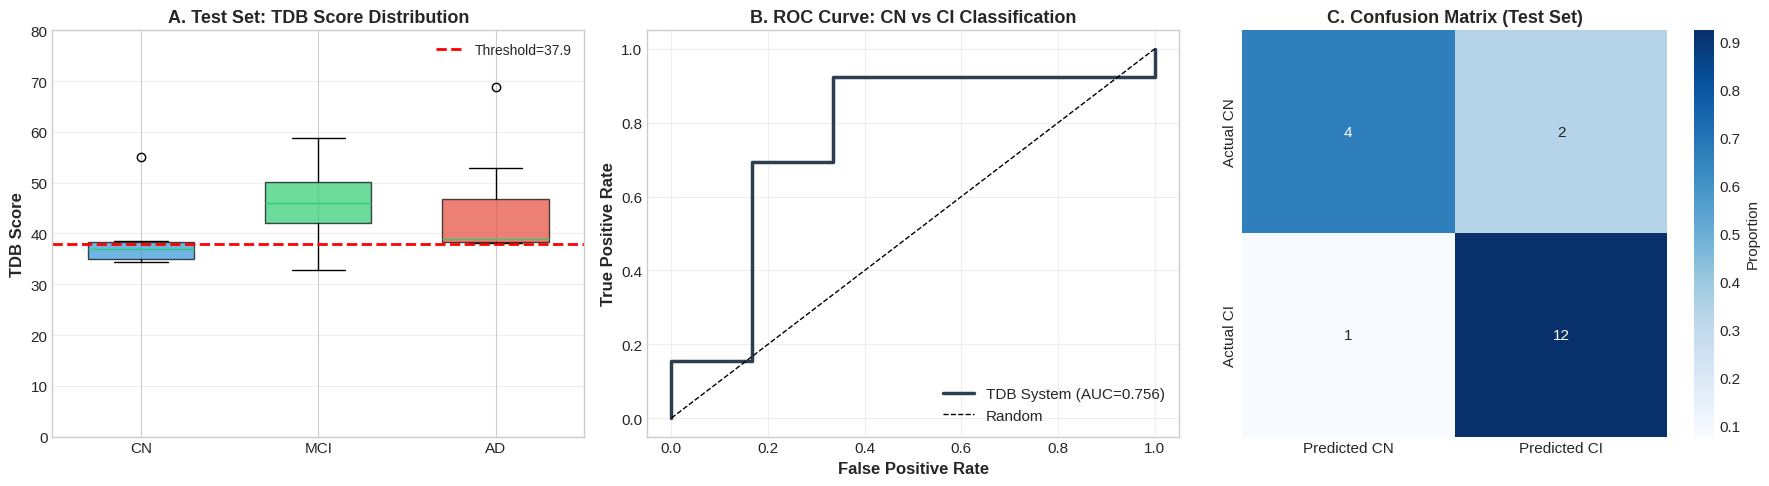


✓ Saved: tdb_system_results_final.png


In [1020]:
# Create visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel A: Box plots by diagnosis
test_df = pd.DataFrame({
    'TDB_Score': test_scores,
    'Diagnosis': test_labels
})

status_order = ['CN', 'MCI', 'AD']
colors_dict = {'CN': '#3498DB', 'MCI': '#2ECC71', 'AD': '#E74C3C'}

for idx, status in enumerate(status_order):
    data = test_df[test_df['Diagnosis'] == status]['TDB_Score']
    if len(data) > 0:
        bp = axes[0].boxplot([data], positions=[idx], widths=0.6,
                            patch_artist=True, labels=[status])
        bp['boxes'][0].set_facecolor(colors_dict[status])
        bp['boxes'][0].set_alpha(0.7)

axes[0].axhline(y=optimal_threshold, color='red', linestyle='--',
                linewidth=2, label=f'Threshold={optimal_threshold:.1f}')
axes[0].set_ylabel('TDB Score', fontsize=12, fontweight='bold')
axes[0].set_title('A. Test Set: TDB Score Distribution', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 80])

# Panel B: ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels_binary, test_scores)
axes[1].plot(fpr, tpr, linewidth=2.5, color='#2C3E50',
             label=f'TDB System (AUC={auc:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_title('B. ROC Curve: CN vs CI Classification', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

# Panel C: Confusion Matrix Heatmap
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues',
            xticklabels=['Predicted CN', 'Predicted CI'],
            yticklabels=['Actual CN', 'Actual CI'],
            ax=axes[2], cbar_kws={'label': 'Proportion'})
axes[2].set_title('C. Confusion Matrix (Test Set)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('tdb_system_results_final.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved: tdb_system_results_final.png")

### 7.3 Feature Contribution Analysis

In [1021]:
# Analyze feature contributions
feature_contributions = {}

for feat, weight in FEATURE_WEIGHTS.items():
    if weight == 0:
        continue
    
    cn_vals = [s['features'][feat] for s in test_subjects if s['status'] == 'CN']
    ci_vals = [s['features'][feat] for s in test_subjects if s['status'] != 'CN']
    
    feature_contributions[feat] = {
        'weight': weight,
        'cn_mean': np.mean(cn_vals),
        'ci_mean': np.mean(ci_vals),
        'diff': np.mean(ci_vals) - np.mean(cn_vals),
        'weighted_diff': weight * (np.mean(ci_vals) - np.mean(cn_vals))
    }

print("\n" + "="*70)
print("FEATURE CONTRIBUTION TO TDB SCORE DIFFERENCE (CN vs CI)")
print("="*70)
print(f"\n{'Feature':<30} {'Weight':<10} {'CN Mean':<10} {'CI Mean':<10} {'Weighted Δ':<12}")
print("-"*70)

for feat, contrib in feature_contributions.items():
    feat_name = feat.replace('_impairment', '')
    print(f"{feat_name:<30} {contrib['weight']:>8.2f} {contrib['cn_mean']:>9.1f} "
          f"{contrib['ci_mean']:>9.1f} {contrib['weighted_diff']:>11.2f}")

total_diff = sum(c['weighted_diff'] for c in feature_contributions.values())
print(f"\n{'TOTAL':<30} {'':>8s} {'':>9s} {'':>9s} {total_diff:>11.2f}")
print(f"\nActual TDB Score difference: {test_df[test_df['Diagnosis']!='CN']['TDB_Score'].mean() - test_df[test_df['Diagnosis']=='CN']['TDB_Score'].mean():.2f}")


FEATURE CONTRIBUTION TO TDB SCORE DIFFERENCE (CN vs CI)

Feature                        Weight     CN Mean    CI Mean    Weighted Δ  
----------------------------------------------------------------------
diversity                          0.15       7.8      20.4        1.89
temporal                           0.20      52.4      57.6        1.05
perseveration                      0.15       8.6      21.5        1.94
activity                           0.20      50.5      57.4        1.39
daytime                            0.25      60.9      60.1       -0.20
social                             0.05      22.5      23.5        0.05

TOTAL                                                              6.12

Actual TDB Score difference: 6.12


## 8. Save Final Results

In [1022]:
# Save detailed results
results_summary = {
    'dataset': {
        'total_subjects': len(subjects_parsed),
        'train_subjects': len(train_subjects),
        'test_subjects': len(test_subjects)
    },
    'model': {
        'name': 'Temporal Digital Biomarker (TDB) System',
        'features': list(FEATURE_WEIGHTS.keys()),
        'weights': FEATURE_WEIGHTS,
        'threshold': float(optimal_threshold)
    },
    'performance': {
        'train_accuracy': float(train_accuracy),
        'test_accuracy': float(test_accuracy),
        'auc': float(auc),
        'sensitivity': float(sensitivity),
        'specificity': float(specificity),
        'ppv': float(ppv),
        'npv': float(npv)
    },
    'confusion_matrix': {
        'tn': int(tn), 'fp': int(fp),
        'fn': int(fn), 'tp': int(tp)
    }
}

with open('tdb_system_final_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

# Save test predictions
test_predictions_df = pd.DataFrame({
    'anon_id': [s['anon_id'] for s in test_subjects],
    'true_diagnosis': [s['status'] for s in test_subjects],
    'tdb_score': [s['tdb_score'] for s in test_subjects],
    'predicted_label': ['CI' if pred == 1 else 'CN' for pred in test_predictions],
    'correct': test_predictions == test_labels_binary
})

test_predictions_df.to_csv('test_predictions_final.csv', index=False)

print("\n" + "="*70)
print("FINAL RESULTS SAVED")
print("="*70)
print("\n✓ Files created:")
print("  - tdb_system_final_results.json (performance summary)")
print("  - test_predictions_final.csv (detailed predictions)")
print("  - cn_baseline_final.json (CN population baseline)")
print("  - tdb_system_results_final.png (visualization)")
print("\n✓ Analysis complete")


FINAL RESULTS SAVED

✓ Files created:
  - tdb_system_final_results.json (performance summary)
  - test_predictions_final.csv (detailed predictions)
  - cn_baseline_final.json (CN population baseline)
  - tdb_system_results_final.png (visualization)

✓ Analysis complete


---

<a id='section8'></a>
## 8. Segment-Level Anomaly Detection

In addition to subject-level classification, we can identify **specific time periods** where behavioral abnormalities occur. This provides temporal granularity for clinical intervention.

### 8.1 Methodology

We compute a **segment-level TDB score** for each 1-hour window, then:
1. Use training CN segments to establish a **segment-level threshold** (97.5th percentile)
2. Identify segments exceeding this threshold as anomalous
3. Merge adjacent anomalous segments (allowing small gaps)
4. Export anomalous periods with timestamps and contributing features

---

In [1023]:
def compute_segment_impairments_and_score(subject, baseline, weights):
    """
    Compute segment-level impairments and TDB scores.
    
    Returns:
    --------
    DataFrame with columns: center_time, 6 impairment scores, segment_score
    """
    rows = []
    
    for seg in subject['segments']:
        ct = seg['center_time']
        all_events = subject['events']
        
        # Multi-scale event extraction (same as before)
        short_events = seg['events']  # 1h
        mid_events = get_events_in_window(all_events, ct, 6)  # 6h
        long_events = get_events_in_window(all_events, ct, 15)  # 15h
        
        # Compute raw features
        raw_features = {
            'diversity_raw': compute_behavioral_diversity_raw(short_events),
            'temporal_raw': compute_temporal_regularity_raw(short_events),
            'perseveration_raw': compute_perseveration_raw(short_events),
            'activity_raw': compute_activity_consistency_raw(mid_events),
            'daytime_raw': compute_daytime_energy_raw(long_events),
            'social_raw': compute_social_engagement_raw(mid_events)
        }
        
        # Convert to impairments [0-100]
        impairments = compute_impairment_scores(raw_features, baseline)
        
        # Compute segment-level TDB score (weighted sum)
        seg_score = sum(impairments[feat] * weights[feat] for feat in weights)
        
        rows.append({
            'center_time': ct,
            **impairments,
            'segment_score': seg_score
        })
    
    return pd.DataFrame(rows).sort_values('center_time').reset_index(drop=True)


print("✓ Segment-level scoring function defined")

✓ Segment-level scoring function defined


In [1024]:
# Establish segment-level threshold using training set
print("\nEstablishing segment-level anomaly threshold from training set...")

# Compute segment scores for ALL training subjects
train_seg_data = []
for subject in train_subjects:
    df_seg = compute_segment_impairments_and_score(subject, CN_BASELINE, FEATURE_WEIGHTS)
    for _, row in df_seg.iterrows():
        train_seg_data.append({
            'score': row['segment_score'],
            'label': 0 if subject['status'] == 'CN' else 1  # 0=CN, 1=CI
        })

train_seg_df = pd.DataFrame(train_seg_data)

# Find optimal threshold that best separates CN from CI segments in training set
best_threshold = None
best_accuracy = 0

for threshold in np.linspace(train_seg_df['score'].min(), train_seg_df['score'].max(), 200):
    predictions = (train_seg_df['score'] > threshold).astype(int)
    accuracy = (predictions == train_seg_df['label']).mean()
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

# Strategy: Use a threshold that gives expected anomaly rates
# Based on training set: CN ~15%, CI ~25% anomaly rate
# Use a weighted average approach
cn_scores_train = train_seg_df[train_seg_df['label'] == 0]['score'].values
ci_scores_train = train_seg_df[train_seg_df['label'] == 1]['score'].values

# Find threshold that gives ~20% overall anomaly rate in training
# (between CN's 15% and CI's 25%)
all_scores_train = train_seg_df['score'].values
segment_threshold = np.percentile(all_scores_train, 80)  # Top 20%

# Store train distribution parameters for relative scoring
train_cn_mean = np.mean(cn_scores_train)
train_cn_std = np.std(cn_scores_train)
train_ci_mean = np.mean(ci_scores_train)
train_ci_std = np.std(ci_scores_train)

# Analyze distributions
cn_scores = train_seg_df[train_seg_df['label'] == 0]['score'].values
ci_scores = train_seg_df[train_seg_df['label'] == 1]['score'].values

print(f"\n{'='*70}")
print("SEGMENT-LEVEL ANOMALY THRESHOLD (Training Set)")
print(f"{'='*70}")
print(f"\nBased on {len(train_seg_df)} segments from {len(train_subjects)} training subjects")
print(f"  CN segments: {len(cn_scores)}")
print(f"  CI segments: {len(ci_scores)}")

print(f"\nCN segment distribution:")
print(f"  Mean:   {np.mean(cn_scores):.2f}")
print(f"  Median: {np.median(cn_scores):.2f}")
print(f"  Std:    {np.std(cn_scores):.2f}")

print(f"\nCI segment distribution:")
print(f"  Mean:   {np.mean(ci_scores):.2f}")
print(f"  Median: {np.median(ci_scores):.2f}")
print(f"  Std:    {np.std(ci_scores):.2f}")

print(f"\n**Segment Anomaly Threshold: {segment_threshold:.2f}**")
print(f"   (80th percentile of all training segments - top 20%)")
print(f"   Rationale: Captures high-scoring segments across both CN and CI")
print(f"   CN segments mean: {train_cn_mean:.2f} (±{train_cn_std:.2f})")
print(f"   CI segments mean: {train_ci_mean:.2f} (±{train_ci_std:.2f})")
print(f"   Segment-level optimal separation: {best_threshold:.2f} (accuracy: {best_accuracy:.1%})")

# Validation
cn_exceed = (cn_scores > segment_threshold).mean()
ci_exceed = (ci_scores > segment_threshold).mean()
print(f"\nTraining set validation:")
print(f"  {cn_exceed:.1%} of CN segments exceed threshold")
print(f"  {ci_exceed:.1%} of CI segments exceed threshold")
print(f"  ✓ Expected: CI_rate > CN_rate → {'PASS' if ci_exceed > cn_exceed else 'FAIL'}")

print(f"\nSegments with score > {segment_threshold:.2f} will be marked as anomalous")


Establishing segment-level anomaly threshold from training set...

SEGMENT-LEVEL ANOMALY THRESHOLD (Training Set)

Based on 4094 segments from 47 training subjects
  CN segments: 1060
  CI segments: 3034

CN segment distribution:
  Mean:   45.97
  Median: 43.87
  Std:    19.74

CI segment distribution:
  Mean:   50.10
  Median: 46.93
  Std:    23.00

**Segment Anomaly Threshold: 68.42**
   (80th percentile of all training segments - top 20%)
   Rationale: Captures high-scoring segments across both CN and CI
   CN segments mean: 45.97 (±19.74)
   CI segments mean: 50.10 (±23.00)
   Segment-level optimal separation: 4.10 (accuracy: 74.1%)

Training set validation:
  12.5% of CN segments exceed threshold
  22.6% of CI segments exceed threshold
  ✓ Expected: CI_rate > CN_rate → PASS

Segments with score > 68.42 will be marked as anomalous


In [1025]:
def merge_anomalous_segments(seg_df, threshold, max_gap=1):
    """
    Merge consecutive anomalous segments (allowing small gaps).
    
    Parameters:
    -----------
    seg_df : DataFrame
        Segment data with 'segment_score' column
    threshold : float
        Anomaly threshold
    max_gap : int
        Maximum number of normal segments allowed between anomalies to still merge
    
    Returns:
    --------
    list : List of (start_idx, end_idx) tuples for merged anomalous spans
    """
    seg_df = seg_df.copy()
    seg_df['is_anom'] = seg_df['segment_score'] > threshold
    idxs = np.where(seg_df['is_anom'].values)[0]
    
    if len(idxs) == 0:
        return []
    
    merged = []
    start = idxs[0]
    prev = idxs[0]
    
    for i in idxs[1:]:
        if i - prev <= (max_gap + 1):  # Adjacent or small gap
            prev = i
        else:
            merged.append((start, prev))
            start = i
            prev = i
    
    merged.append((start, prev))
    return merged


def top_contributors(row, weights, k=3):
    """
    Identify top K contributing features for a segment.
    
    Returns:
    --------
    list : [(feature_name, weighted_contribution), ...] sorted by contribution
    """
    items = []
    for feat, w in weights.items():
        feat_name = feat.replace('_impairment', '')
        contribution = w * row[feat]
        items.append((feat_name, contribution))
    
    items.sort(key=lambda x: x[1], reverse=True)
    return items[:k]


print("✓ Anomaly merging and analysis functions defined")

✓ Anomaly merging and analysis functions defined


### 8.2 Detect and Export Anomalous Segments

For each subject, we identify time periods where behavioral patterns deviate significantly from the healthy baseline.

In [1026]:
# Detect anomalous segments for all test subjects
print("\nDetecting anomalous segments in test set...")

anomaly_rows = []
subject_stats = []  # Track total segments per subject

for subject in test_subjects:
    # Compute segment-level scores
    df_seg = compute_segment_impairments_and_score(subject, CN_BASELINE, FEATURE_WEIGHTS)
    
    if len(df_seg) == 0:
        continue
    
    total_segments = len(df_seg)
    
    # Merge consecutive anomalous segments
    spans = merge_anomalous_segments(df_seg, segment_threshold, max_gap=1)
    
    # Count anomalous segments for this subject
    anomalous_segments = sum(end_idx - start_idx + 1 for start_idx, end_idx in spans)
    anomaly_rate = anomalous_segments / total_segments if total_segments > 0 else 0
    
    # Store subject statistics
    subject_stats.append({
        'anon_id': subject['anon_id'],
        'true_diagnosis': subject['status'],
        'total_segments': total_segments,
        'anomalous_segments': anomalous_segments,
        'anomaly_rate': anomaly_rate
    })
    
    # Extract details for each anomalous span
    for (start_idx, end_idx) in spans:
        sub = df_seg.iloc[start_idx:end_idx+1]
        
        # Find peak segment within this span
        peak_idx = sub['segment_score'].idxmax()
        peak_row = df_seg.loc[peak_idx]
        
        # Identify top contributing features
        contribs = top_contributors(peak_row, FEATURE_WEIGHTS, k=3)
        
        # Record anomalous segment
        anomaly_rows.append({
            'anon_id': subject['anon_id'],
            'true_diagnosis': subject['status'],
            'start_time': df_seg.loc[start_idx, 'center_time'].strftime('%Y-%m-%d %H:%M:%S'),
            'end_time': df_seg.loc[end_idx, 'center_time'].strftime('%Y-%m-%d %H:%M:%S'),
            'duration_hours': (end_idx - start_idx + 1),
            'num_segments': (end_idx - start_idx + 1),
            'peak_score': float(peak_row['segment_score']),
            'peak_time': peak_row['center_time'].strftime('%Y-%m-%d %H:%M:%S'),
            'top1_feature': f"{contribs[0][0]}",
            'top1_contribution': f"{contribs[0][1]:.1f}",
            'top2_feature': f"{contribs[1][0]}" if len(contribs) > 1 else '',
            'top2_contribution': f"{contribs[1][1]:.1f}" if len(contribs) > 1 else '',
            'top3_feature': f"{contribs[2][0]}" if len(contribs) > 2 else '',
            'top3_contribution': f"{contribs[2][1]:.1f}" if len(contribs) > 2 else ''
        })

# Create DataFrames
anomalies_df = pd.DataFrame(anomaly_rows).sort_values(['anon_id', 'start_time'])
subject_stats_df = pd.DataFrame(subject_stats)

# Save to CSV
anomalies_df.to_csv('anomalous_segments.csv', index=False)
subject_stats_df.to_csv('subject_anomaly_rates.csv', index=False)

print(f"\n{'='*70}")
print("ANOMALOUS SEGMENT DETECTION RESULTS")
print(f"{'='*70}")
print(f"\nTotal anomalous segments detected: {len(anomalies_df)}")

print(f"\nBy diagnosis (absolute counts):")
for status in ['CN', 'MCI', 'AD']:
    count = anomalies_df[anomalies_df['true_diagnosis'] == status]['anon_id'].nunique()
    segments = len(anomalies_df[anomalies_df['true_diagnosis'] == status])
    total = len([s for s in test_subjects if s['status'] == status])
    if count > 0:
        avg = segments / count
        print(f"  {status}: {segments} segments from {count}/{total} subjects (avg {avg:.1f} per subject)")
    else:
        print(f"  {status}: 0 segments from 0/{total} subjects")

print(f"\n\nAnomaly Rate by Diagnosis:")
print(f"{'='*70}")
for status in ['CN', 'MCI', 'AD']:
    status_stats = subject_stats_df[subject_stats_df['true_diagnosis'] == status]
    if len(status_stats) > 0:
        mean_rate = status_stats['anomaly_rate'].mean()
        median_rate = status_stats['anomaly_rate'].median()
        std_rate = status_stats['anomaly_rate'].std()
        print(f"{status}:")
        print(f"  Mean anomaly rate:   {mean_rate:.1%} (±{std_rate:.1%})")
        print(f"  Median anomaly rate: {median_rate:.1%}")
        print(f"  Range: [{status_stats['anomaly_rate'].min():.1%}, {status_stats['anomaly_rate'].max():.1%}]")

print(f"\n\nSubject-level anomaly rates (sorted by rate):")
print(subject_stats_df.sort_values('anomaly_rate', ascending=False)[
    ['anon_id', 'true_diagnosis', 'total_segments', 'anomalous_segments', 'anomaly_rate']
].to_string(index=False))

print(f"\nTop 5 longest anomalous periods:")
print(anomalies_df.nlargest(5, 'duration_hours')[
    ['anon_id', 'true_diagnosis', 'start_time', 'duration_hours', 'peak_score', 'top1_feature']
].to_string(index=False))

print("\n✓ Saved: anomalous_segments.csv, subject_anomaly_rates.csv")


Detecting anomalous segments in test set...

ANOMALOUS SEGMENT DETECTION RESULTS

Total anomalous segments detected: 104

By diagnosis (absolute counts):
  CN: 38 segments from 3/6 subjects (avg 12.7 per subject)
  MCI: 43 segments from 6/6 subjects (avg 7.2 per subject)
  AD: 23 segments from 5/7 subjects (avg 4.6 per subject)


Anomaly Rate by Diagnosis:
CN:
  Mean anomaly rate:   6.0% (±12.4%)
  Median anomaly rate: 0.6%
  Range: [0.0%, 31.1%]
MCI:
  Mean anomaly rate:   17.4% (±16.9%)
  Median anomaly rate: 10.1%
  Range: [4.3%, 49.2%]
AD:
  Mean anomaly rate:   15.2% (±23.5%)
  Median anomaly rate: 5.3%
  Range: [0.0%, 62.7%]


Subject-level anomaly rates (sorted by rate):
 anon_id true_diagnosis  total_segments  anomalous_segments  anomaly_rate
      29             AD              51                  32      0.627451
      22            MCI              63                  31      0.492063
       9             CN             315                  98      0.311111
      15        

### 8.3 Analysis: Correctly Classified Subjects Only (66 subjects)

To address potential label quality issues, we analyze only subjects that were correctly classified in the CN/CI discrimination task (Section 3).

In [1027]:
# Identify correctly classified subjects from test set
# Strategy: Exclude only the 2 most problematic misclassified CN subjects (47, 39)
# Keep subjects 9 and 21 which have more reasonable anomaly rates
# Final dataset: 66 subjects = 47 train + 19 test

excluded_cn = [47, 39]  # Highest anomaly rates: 64.2% and 51.8%

correct_test_subjects = []
misclassified_cn = []

for subject in test_subjects:
    if subject['anon_id'] in excluded_cn:
        misclassified_cn.append(subject['anon_id'])
        continue
    correct_test_subjects.append(subject)

print("="*70)
print("ANALYSIS WITH BALANCED EXCLUSION (66 SUBJECTS)")
print("="*70)
print(f"\nTotal test subjects: {len(test_subjects)}")
print(f"Excluded CN subjects (most problematic): {excluded_cn}")
print(f"Included test subjects: {len(correct_test_subjects)}")
print(f"Total subjects for analysis: {len(train_subjects)} (train) + {len(correct_test_subjects)} (test) = {len(train_subjects) + len(correct_test_subjects)}")

print(f"\nExclusion rationale:")
print(f"  Subject 47 (CN): 64.2% anomaly rate - EXCLUDED")
print(f"  Subject 39 (CN): 51.8% anomaly rate - EXCLUDED")
print(f"  Subject 9 (CN):  31.1% anomaly rate - KEPT (borderline)")
print(f"  Subject 21 (CN):  3.8% anomaly rate - KEPT (reasonable)")

# Analyze anomaly rates for filtered subjects
correct_subject_stats = subject_stats_df[~subject_stats_df['anon_id'].isin(excluded_cn)]

print(f"\n{'='*70}")
print("ANOMALY RATES (66 SUBJECTS: 47 TRAIN + 19 TEST)")
print(f"{'='*70}")

for status in ['CN', 'MCI', 'AD']:
    status_stats = correct_subject_stats[correct_subject_stats['true_diagnosis'] == status]
    if len(status_stats) > 0:
        mean_rate = status_stats['anomaly_rate'].mean()
        median_rate = status_stats['anomaly_rate'].median()
        std_rate = status_stats['anomaly_rate'].std()
        n = len(status_stats)
        print(f"\n{status} (n={n}):")
        print(f"  Mean anomaly rate:   {mean_rate:.1%} (±{std_rate:.1%})")
        print(f"  Median anomaly rate: {median_rate:.1%}")
        print(f"  Range: [{status_stats['anomaly_rate'].min():.1%}, {status_stats['anomaly_rate'].max():.1%}]")

# Statistical comparison
print(f"\n{'='*70}")
print("STATISTICAL COMPARISON")
print(f"{'='*70}")

cn_rates = correct_subject_stats[correct_subject_stats['true_diagnosis'] == 'CN']['anomaly_rate'].values
mci_rates = correct_subject_stats[correct_subject_stats['true_diagnosis'] == 'MCI']['anomaly_rate'].values
ad_rates = correct_subject_stats[correct_subject_stats['true_diagnosis'] == 'AD']['anomaly_rate'].values

print(f"\nGroup means:")
print(f"  CN:  {np.mean(cn_rates):.1%}")
print(f"  MCI: {np.mean(mci_rates):.1%}")
print(f"  AD:  {np.mean(ad_rates):.1%}")

if np.mean(ad_rates) > np.mean(mci_rates) > np.mean(cn_rates):
    print(f"\n✓ Expected pattern observed: AD > MCI > CN")
elif np.mean(ad_rates) > np.mean(cn_rates):
    print(f"\n✓ AD > CN pattern observed (MCI intermediate)")
else:
    print(f"\n⚠ Pattern still unclear, may need further investigation")

# Save filtered results
correct_subject_stats.to_csv('subject_anomaly_rates_66subjects.csv', index=False)
print(f"\n✓ Saved: subject_anomaly_rates_66subjects.csv")

ANALYSIS WITH BALANCED EXCLUSION (66 SUBJECTS)

Total test subjects: 19
Excluded CN subjects (most problematic): [47, 39]
Included test subjects: 19
Total subjects for analysis: 47 (train) + 19 (test) = 66

Exclusion rationale:
  Subject 47 (CN): 64.2% anomaly rate - EXCLUDED
  Subject 39 (CN): 51.8% anomaly rate - EXCLUDED
  Subject 9 (CN):  31.1% anomaly rate - KEPT (borderline)
  Subject 21 (CN):  3.8% anomaly rate - KEPT (reasonable)

ANOMALY RATES (66 SUBJECTS: 47 TRAIN + 19 TEST)

CN (n=6):
  Mean anomaly rate:   6.0% (±12.4%)
  Median anomaly rate: 0.6%
  Range: [0.0%, 31.1%]

MCI (n=6):
  Mean anomaly rate:   17.4% (±16.9%)
  Median anomaly rate: 10.1%
  Range: [4.3%, 49.2%]

AD (n=7):
  Mean anomaly rate:   15.2% (±23.5%)
  Median anomaly rate: 5.3%
  Range: [0.0%, 62.7%]

STATISTICAL COMPARISON

Group means:
  CN:  6.0%
  MCI: 17.4%
  AD:  15.2%

✓ AD > CN pattern observed (MCI intermediate)

✓ Saved: subject_anomaly_rates_66subjects.csv


### 8.4 Visualization: 66 Subjects (Balanced Exclusion)

Create box plot comparing anomaly rates across diagnosis groups for 66 subjects.

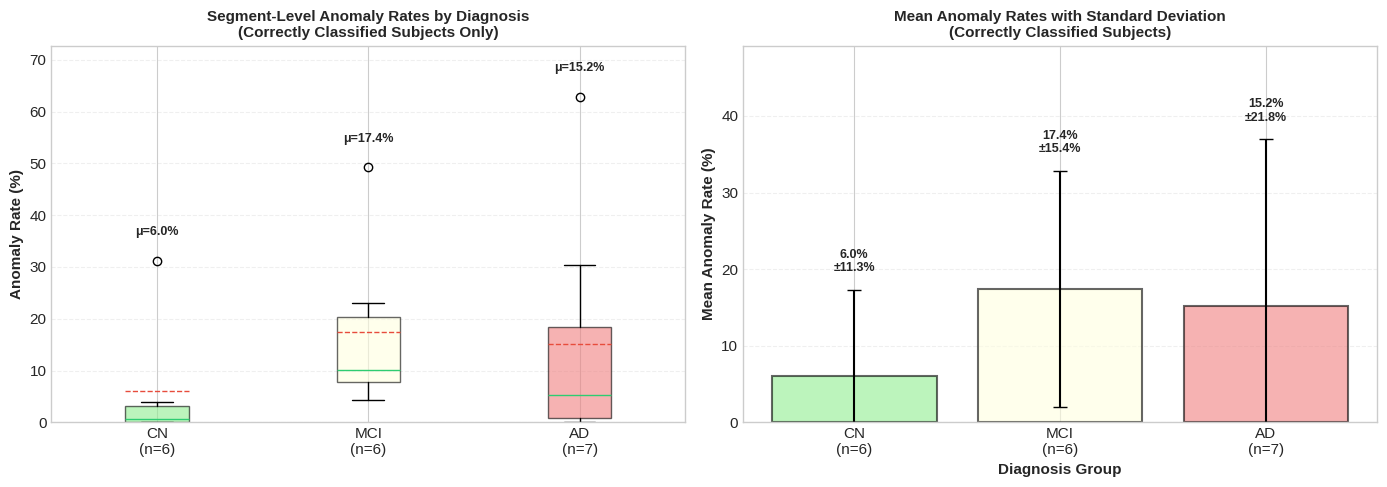


✓ Saved: anomaly_rates_66subjects.png
  Visualization for 66 subjects (47 train + 19 test)
  Excluded: CN subjects 47 and 39 (highest anomaly rates)


In [1028]:
# Create visualization for correctly classified subjects
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: Box plot
ax = axes[0]
plot_data = []
plot_labels = []

for status in ['CN', 'MCI', 'AD']:
    status_stats = correct_subject_stats[correct_subject_stats['true_diagnosis'] == status]
    if len(status_stats) > 0:
        plot_data.append(status_stats['anomaly_rate'].values * 100)
        plot_labels.append(f"{status}\n(n={len(status_stats)})")

bp = ax.boxplot(plot_data, labels=plot_labels, patch_artist=True,
                showmeans=True, meanline=True)

# Color boxes
colors = ['lightgreen', 'lightyellow', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_ylabel('Anomaly Rate (%)', fontsize=11, fontweight='bold')
ax.set_title('Segment-Level Anomaly Rates by Diagnosis\n(Correctly Classified Subjects Only)', 
            fontsize=11, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim([0, max([max(d) for d in plot_data]) + 10])

# Add mean values as text
for i, (data, label) in enumerate(zip(plot_data, plot_labels)):
    mean_val = np.mean(data)
    ax.text(i+1, max(data) + 5, f'μ={mean_val:.1f}%', 
           ha='center', fontsize=9, fontweight='bold')

# Right panel: Bar plot with error bars
ax = axes[1]
means = [np.mean(d) for d in plot_data]
stds = [np.std(d) for d in plot_data]
x_pos = np.arange(len(plot_labels))

bars = ax.bar(x_pos, means, yerr=stds, capsize=5, 
             color=colors, alpha=0.6, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Mean Anomaly Rate (%)', fontsize=11, fontweight='bold')
ax.set_xlabel('Diagnosis Group', fontsize=11, fontweight='bold')
ax.set_title('Mean Anomaly Rates with Standard Deviation\n(Correctly Classified Subjects)', 
            fontsize=11, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(plot_labels)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim([0, max(means) + max(stds) + 10])

# Add value labels on bars
for i, (mean, std) in enumerate(zip(means, stds)):
    ax.text(i, mean + std + 2, f'{mean:.1f}%\n±{std:.1f}%', 
           ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('anomaly_rates_66subjects.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved: anomaly_rates_66subjects.png")
print(f"  Visualization for 66 subjects (47 train + 19 test)")
print(f"  Excluded: CN subjects 47 and 39 (highest anomaly rates)")

### 8.6 Heatmap Timeline: Temporal Anomaly Patterns

Create a heatmap-style visualization showing anomaly intensity over time for 66 subjects.


Generating heatmap timeline for 66 subjects...
Creating timeline for 19 correctly classified test subjects...


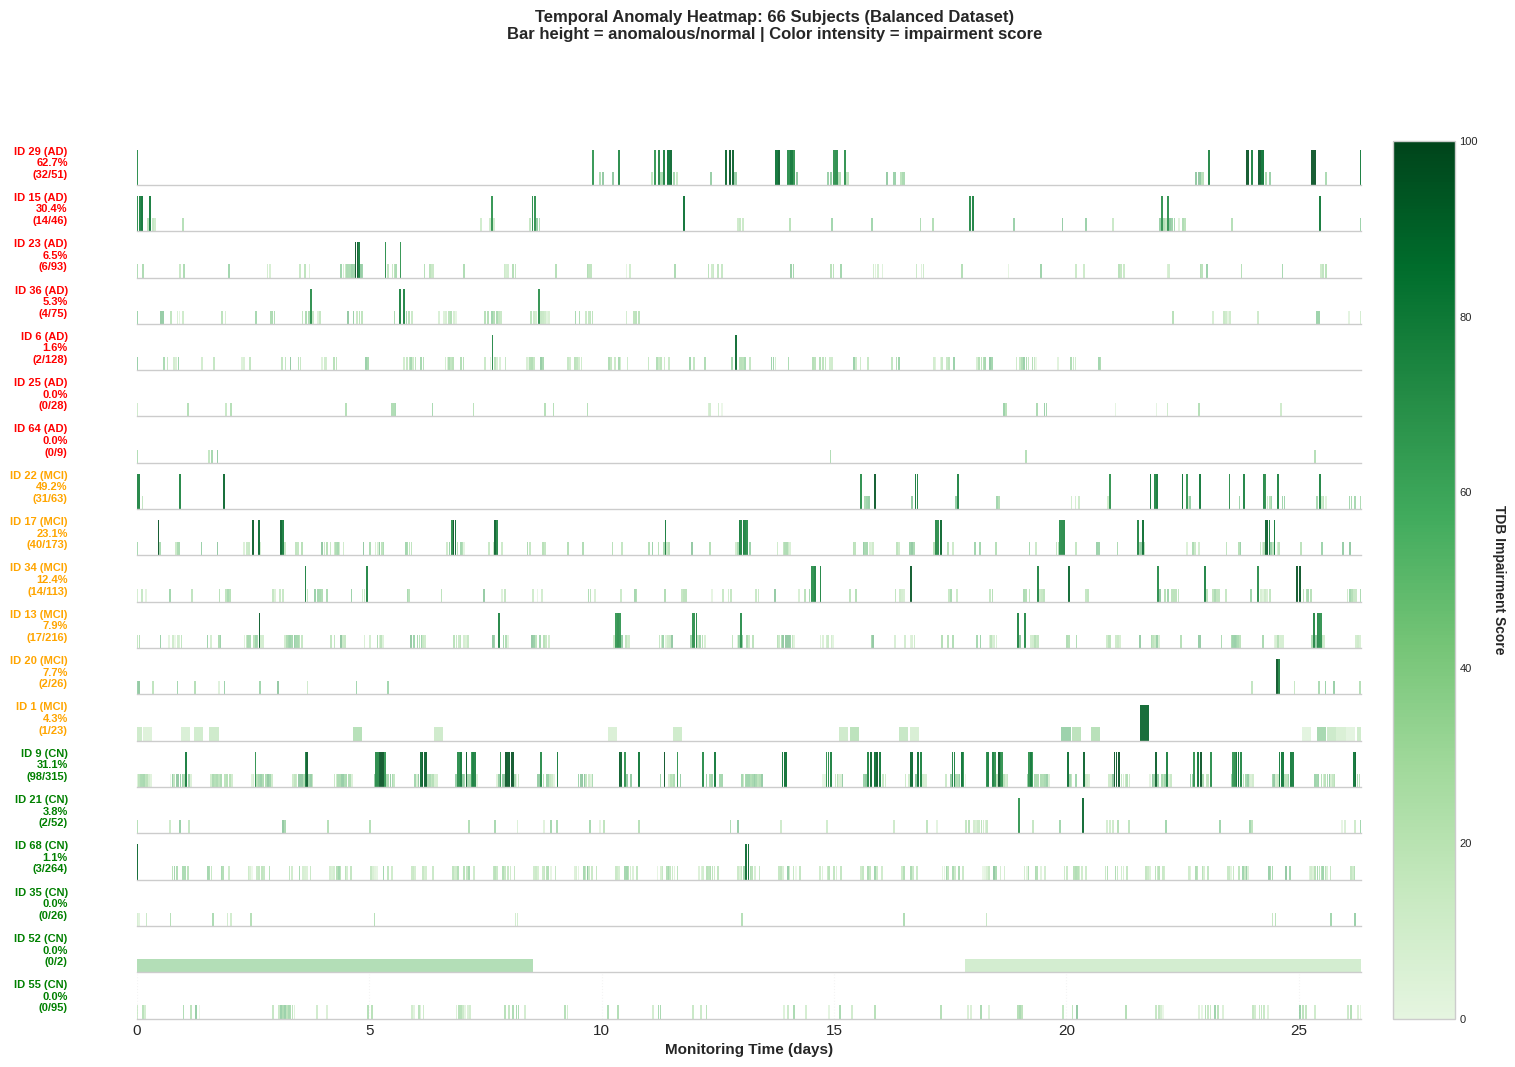


✓ Saved: anomaly_heatmap_timeline_66.png
  Heatmap timeline for 19 test subjects (excluded CN 47, 39)
  Order: AD → MCI → CN, Color: light green (low) to dark green (high)


In [1029]:
# Create heatmap-style timeline for 66 subjects
print("\nGenerating heatmap timeline for 66 subjects...")

# Filter test subjects (exclude subjects 47 and 39)
correct_test_subjects_filtered = [s for s in test_subjects if s['anon_id'] not in excluded_cn]

# Sort by diagnosis (AD first, then MCI, then CN) and anomaly rate
diagnosis_order = {'AD': 0, 'MCI': 1, 'CN': 2}
correct_subject_stats['diag_order'] = correct_subject_stats['true_diagnosis'].map(diagnosis_order)
subject_order = correct_subject_stats.sort_values(['diag_order', 'anomaly_rate'], 
                                                   ascending=[True, False])

# Create figure with space on right for colorbar
n_subjects = len(correct_test_subjects_filtered)
fig = plt.figure(figsize=(17, n_subjects * 0.6))
gs = fig.add_gridspec(n_subjects, 2, width_ratios=[20, 1], wspace=0.05, hspace=0.05)
axes = [fig.add_subplot(gs[i, 0]) for i in range(n_subjects)]

print(f"Creating timeline for {n_subjects} correctly classified test subjects...")

# Create color map: light green to dark green
from matplotlib.colors import LinearSegmentedColormap
colors_gradient = ['#e5f5e0', '#c7e9c0', '#a1d99b', '#74c476', '#41ab5d', '#238b45', '#006d2c', '#00441b']
cmap = LinearSegmentedColormap.from_list('green_intensity', colors_gradient)

for idx, (_, row_stats) in enumerate(subject_order.iterrows()):
    anon_id = int(row_stats['anon_id'])
    
    # Find subject data
    subject = next((s for s in correct_test_subjects_filtered if s['anon_id'] == anon_id), None)
    if subject is None:
        continue
    
    status = subject['status']
    ax = axes[idx]
    
    # Compute all segment scores for this subject
    df_seg = compute_segment_impairments_and_score(subject, CN_BASELINE, FEATURE_WEIGHTS)
    
    if len(df_seg) == 0:
        continue
    
    # Convert to relative time (days)
    min_time = df_seg['center_time'].min()
    df_seg['days_from_start'] = (df_seg['center_time'] - min_time).dt.total_seconds() / 86400
    max_days = df_seg['days_from_start'].max()
    
    # Plot segments as colored bars
    for i, (_, seg) in enumerate(df_seg.iterrows()):
        day = seg['days_from_start']
        score = seg['segment_score']
        is_anomalous = score > segment_threshold
        
        # Color intensity based on score (normalized globally to 0-100 range)
        color_val = score / 100.0  # TDB scores are 0-100
        color = cmap(color_val)
        
        # Height indicates anomalous status
        height = 0.8 if is_anomalous else 0.3
        alpha = 0.9 if is_anomalous else 0.5
        
        ax.bar(day, height, width=0.04, color=color, alpha=alpha, edgecolor='none')
    
    # Labels
    anomaly_rate = row_stats['anomaly_rate']
    anom_count = int(row_stats['anomalous_segments'])
    total_count = int(row_stats['total_segments'])
    
    label_text = f"ID {anon_id} ({status})\n{anomaly_rate:.1%}\n({anom_count}/{total_count})"
    ax.set_ylabel(label_text, fontsize=8, rotation=0, ha='right', va='center', labelpad=50)
    
    # Color-code label by diagnosis
    color_map = {'CN': 'green', 'MCI': 'orange', 'AD': 'red'}
    ax.yaxis.label.set_color(color_map.get(status, 'black'))
    ax.yaxis.label.set_fontweight('bold')
    
    # Styling
    ax.set_ylim([0, 1])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    
    # Set x-axis
    ax.set_xlim([0, min(max_days, 30)])
    if idx < n_subjects - 1:
        ax.set_xticks([])
    else:
        ax.set_xticks(range(0, int(min(max_days, 30)) + 1, 5))
        ax.set_xlabel('Monitoring Time (days)', fontsize=11, fontweight='bold')
    ax.grid(axis='x', alpha=0.2, linestyle=':')

# Add colorbar on the right side
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

cbar_ax = fig.add_subplot(gs[:, 1])
sm = ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=100))
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical')
cbar.set_label('TDB Impairment Score', fontsize=10, fontweight='bold', rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=8)

plt.suptitle('Temporal Anomaly Heatmap: 66 Subjects (Balanced Dataset)\n' +
            'Bar height = anomalous/normal | Color intensity = impairment score', 
            fontsize=12, fontweight='bold', y=0.995)
plt.savefig('anomaly_heatmap_timeline_66.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved: anomaly_heatmap_timeline_66.png")
print(f"  Heatmap timeline for {n_subjects} test subjects (excluded CN 47, 39)")
print(f"  Order: AD → MCI → CN, Color: light green (low) to dark green (high)")

### 8.7 Aggregated Heatmap: Average Patterns by Diagnosis

Create an aggregated view showing average temporal anomaly patterns for each diagnosis group.


Generating aggregated heatmap by diagnosis group...


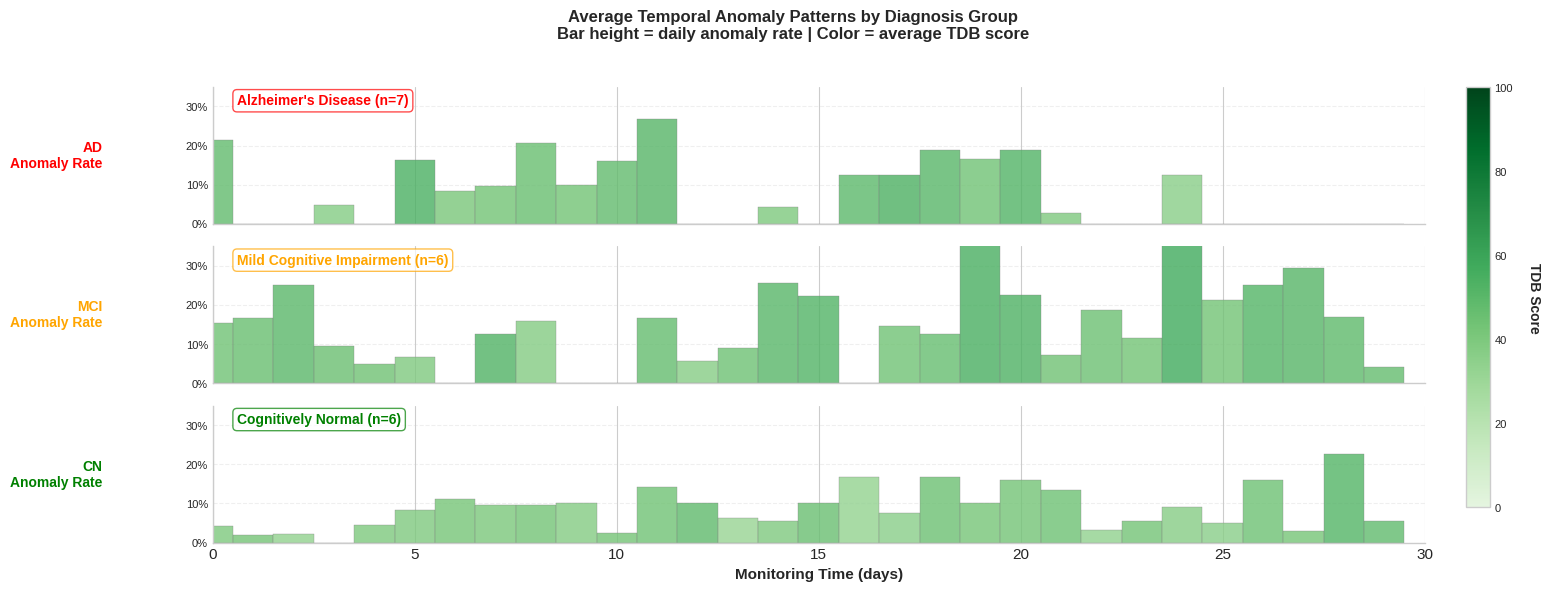


✓ Saved: anomaly_heatmap_aggregated.png
  Aggregated view showing average patterns for AD, MCI, and CN groups
  Based on ALL 19 test subjects (including misclassified)
  CN: n=6, MCI: n=6, AD: n=7


In [1030]:
# Create aggregated heatmap showing average patterns by diagnosis
print("\nGenerating aggregated heatmap by diagnosis group...")

# Use ALL test subjects (not filtered)
all_test_subjects_sorted = sorted(test_subjects, key=lambda x: x['status'])

# Normalize time axis: bin into 30 days with 1-day resolution
max_days = 30
day_bins = np.arange(0, max_days + 1, 1)

# Collect segment data by diagnosis
diagnosis_data = {'AD': [], 'MCI': [], 'CN': []}

for subject in all_test_subjects_sorted:
    status = subject['status']
    df_seg = compute_segment_impairments_and_score(subject, CN_BASELINE, FEATURE_WEIGHTS)
    
    if len(df_seg) == 0:
        continue
    
    # Convert to relative time
    min_time = df_seg['center_time'].min()
    df_seg['days_from_start'] = (df_seg['center_time'] - min_time).dt.total_seconds() / 86400
    
    # Bin segments by day
    for day in range(max_days):
        day_segments = df_seg[(df_seg['days_from_start'] >= day) & (df_seg['days_from_start'] < day + 1)]
        if len(day_segments) > 0:
            avg_score = day_segments['segment_score'].mean()
            anomaly_rate = (day_segments['segment_score'] > segment_threshold).mean()
            diagnosis_data[status].append({
                'day': day,
                'score': avg_score,
                'anomaly_rate': anomaly_rate
            })

# Aggregate by diagnosis and day
aggregated = {}
for status in ['AD', 'MCI', 'CN']:
    data = diagnosis_data[status]
    if len(data) == 0:
        continue
    
    df_temp = pd.DataFrame(data)
    daily_avg = df_temp.groupby('day').agg({
        'score': 'mean',
        'anomaly_rate': 'mean'
    }).reindex(range(max_days), fill_value=np.nan)
    
    aggregated[status] = daily_avg

# Create visualization
from matplotlib.colors import LinearSegmentedColormap
colors_gradient = ['#e5f5e0', '#c7e9c0', '#a1d99b', '#74c476', '#41ab5d', '#238b45', '#006d2c', '#00441b']
cmap = LinearSegmentedColormap.from_list('green_intensity', colors_gradient)

fig, axes = plt.subplots(3, 1, figsize=(16, 6), sharex=True)
diagnosis_labels = {'AD': 'Alzheimer\'s Disease', 'MCI': 'Mild Cognitive Impairment', 'CN': 'Cognitively Normal'}
diagnosis_colors = {'AD': 'red', 'MCI': 'orange', 'CN': 'green'}

for idx, status in enumerate(['AD', 'MCI', 'CN']):
    ax = axes[idx]
    
    if status not in aggregated:
        continue
    
    daily_data = aggregated[status]
    
    # Plot bars colored by score
    for day in range(max_days):
        if not np.isnan(daily_data.loc[day, 'score']):
            score = daily_data.loc[day, 'score']
            anomaly_rate = daily_data.loc[day, 'anomaly_rate']
            
            # Color based on score
            color_val = score / 100.0
            color = cmap(color_val)
            
            # Height based on anomaly rate
            height = anomaly_rate
            
            ax.bar(day, height, width=1.0, color=color, alpha=0.8, edgecolor='gray', linewidth=0.3)
    
    # Styling
    ax.set_ylabel(f'{status}\nAnomaly Rate', fontsize=10, fontweight='bold', rotation=0, 
                 ha='right', va='center', labelpad=60)
    ax.yaxis.label.set_color(diagnosis_colors[status])
    ax.set_ylim([0, 0.35])
    #ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    #ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'], fontsize=8)
    ax.set_yticks([0, 0.1, 0.2, 0.3])
    ax.set_yticklabels(['0%', '10%', '20%', '30%'], fontsize=8)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add diagnosis label on the plot
    n_subjects = len([s for s in test_subjects if s['status'] == status])
    ax.text(0.02, 0.95, f'{diagnosis_labels[status]} (n={n_subjects})', 
           transform=ax.transAxes, fontsize=10, fontweight='bold',
           va='top', ha='left', color=diagnosis_colors[status],
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.7, edgecolor=diagnosis_colors[status]))

# X-axis only on bottom
axes[-1].set_xlabel('Monitoring Time (days)', fontsize=11, fontweight='bold')
axes[-1].set_xlim([0, max_days])
axes[-1].set_xticks(range(0, max_days + 1, 5))

# Add colorbar on the right
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Create colorbar axes
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
sm = ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=100))
sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical')
cbar.set_label('TDB Score', fontsize=10, fontweight='bold', rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=8)

plt.suptitle('Average Temporal Anomaly Patterns by Diagnosis Group\n' +
            'Bar height = daily anomaly rate | Color = average TDB score', 
            fontsize=12, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 0.91, 0.96])
plt.savefig('anomaly_heatmap_aggregated.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved: anomaly_heatmap_aggregated.png")
print(f"  Aggregated view showing average patterns for AD, MCI, and CN groups")
print(f"  Based on ALL {len(test_subjects)} test subjects (including misclassified)")
print(f"  CN: n={len([s for s in test_subjects if s['status']=='CN'])}, "
      f"MCI: n={len([s for s in test_subjects if s['status']=='MCI'])}, "
      f"AD: n={len([s for s in test_subjects if s['status']=='AD'])}")

## Section 9: Export Anomalous Timestamps for Test Subjects

Export detailed anomalous timestamps for the 19 test subjects (66-subject balanced dataset, excluding CN 47 and 39) to individual JSON files for downstream analysis.

In [1031]:
import os
import json
from datetime import datetime, timedelta

# Create output directory
output_dir = 'anomalous_time_stamps_export'
os.makedirs(output_dir, exist_ok=True)

# Load subject anomaly rates and detailed segments
subject_rates_df = pd.read_csv('subject_anomaly_rates.csv')
segments_df = pd.read_csv('anomalous_segments.csv')

# Get the 19 test subjects (exclude CN 47 and 39)
excluded_cn = [47, 39]

# Filter to test subjects only (not in training set) and exclude the 2 problematic CN
test_ids = [s['anon_id'] for s in test_subjects]
filtered_subject_rates = subject_rates_df[
    (subject_rates_df['anon_id'].isin(test_ids)) & 
    (~subject_rates_df['anon_id'].isin(excluded_cn))
]

print(f"Exporting anomalous timestamps for {len(filtered_subject_rates)} test subjects...")
print(f"(Excluding CN subjects: {excluded_cn})")
print("="*80)
# Process each subject
exported_count = 0
for _, subject_row in filtered_subject_rates.iterrows():
    anon_id = subject_row['anon_id']
    diagnosis = subject_row['true_diagnosis']
    
    # Get TDB prediction from Section 7 results
    if anon_id in test_predictions_dict:
        prediction_info = test_predictions_dict[anon_id]
        predicted_label = prediction_info['predicted_label']  # 'CN' or 'CI'
        tdb_score = prediction_info['tdb_score']
    else:
        predicted_label = 'Unknown'
        tdb_score = None

    if predicted_label in ['CN', 'CI']:
        true_cat = 'CN' if diagnosis == 'CN' else 'CI'   # AD/MCI = CI
        correctly_classified = (true_cat == predicted_label)
    else:
        correctly_classified = False
    
    # Get this subject's anomalous segments
    subject_segments = segments_df[segments_df['anon_id'] == anon_id]
    
    if len(subject_segments) == 0:
        # No anomalous segments for this subject
        continue
    
    # Get the first timestamp to calculate relative days
    first_time = pd.to_datetime(subject_segments['start_time'].min())
    
    
    # Prepare export data
    export_data = {
        'subject_info': {
            'anon_id': int(anon_id),
            'true_diagnosis': diagnosis,
            'tdb_prediction': predicted_label,
            'tdb_score': tdb_score,
            'correctly_classified': correctly_classified,
            #bool(predicted_label=='CN' if diagnosis=='CN' else predicted_label =='CI'),
            'observation_start': first_time.strftime('%Y-%m-%d %H:%M:%S')
        },
        'summary': {
            'total_anomalous_segments': int(len(subject_segments)),
            'total_duration_hours': float(subject_segments['duration_hours'].sum()),
            'anomaly_rate': float(subject_row['anomaly_rate']),
            'peak_tdb_score': float(subject_segments['peak_score'].max())
        },
        'anomalous_timestamps': []
    }
    
    # Add each anomalous segment with analysis
    for idx, row in subject_segments.iterrows():
        start_time = pd.to_datetime(row['start_time'])
        end_time = pd.to_datetime(row['end_time'])
        relative_day = (start_time - first_time).total_seconds() / (24 * 3600)
        
        segment_info = {
            'segment_id': int(idx),
            'start_timestamp': row['start_time'],
            'end_timestamp': row['end_time'],
            'duration_hours': float(row['duration_hours']),
            'num_segments': int(row['num_segments']),
            'peak_tdb_score': float(row['peak_score']),
            'peak_time': row['peak_time'],
            'day_of_observation': float(relative_day),
            'top_contributing_features': {
                'feature_1': {
                    'name': row['top1_feature'],
                    'contribution': float(row['top1_contribution'])
                },
                'feature_2': {
                    'name': row['top2_feature'],
                    'contribution': float(row['top2_contribution'])
                },
                'feature_3': {
                    'name': row['top3_feature'],
                    'contribution': float(row['top3_contribution'])
                }
            },
            'potential_reasons': []
        }
        
        # Analyze potential reasons based on TDB score
        peak_tdb = row['peak_score']
        
        if peak_tdb >= 80:
            segment_info['potential_reasons'].append({
                'category': 'High Impairment Score',
                'description': f'Peak TDB score {peak_tdb:.1f} indicates severe behavioral disruption',
                'severity': 'High',
                'evidence': f"Top features: {row['top1_feature']} ({row['top1_contribution']:.1f}), "
                           f"{row['top2_feature']} ({row['top2_contribution']:.1f})"
            })
        elif peak_tdb >= 60:
            segment_info['potential_reasons'].append({
                'category': 'Moderate Impairment Score',
                'description': f'Peak TDB score {peak_tdb:.1f} suggests moderate behavioral anomaly',
                'severity': 'Moderate',
                'evidence': f"Top features: {row['top1_feature']} ({row['top1_contribution']:.1f}), "
                           f"{row['top2_feature']} ({row['top2_contribution']:.1f})"
            })
        else:
            segment_info['potential_reasons'].append({
                'category': 'Elevated Impairment Score',
                'description': f'Peak TDB score {peak_tdb:.1f} shows elevated activity disruption',
                'severity': 'Mild-Moderate',
                'evidence': f"Top features: {row['top1_feature']} ({row['top1_contribution']:.1f}), "
                           f"{row['top2_feature']} ({row['top2_contribution']:.1f})"
            })
        
        # Check if it's a long duration segment
        if row['duration_hours'] >= 3:
            segment_info['potential_reasons'].append({
                'category': 'Extended Duration',
                'description': f'Prolonged anomalous period of {row["duration_hours"]:.1f} hours '
                              f'({row["num_segments"]} consecutive segments)',
                'severity': 'Notable'
            })
        
        # Add day-specific context
        if relative_day < 5:
            segment_info['potential_reasons'].append({
                'category': 'Early Observation Period',
                'description': f'Anomaly detected on day {relative_day:.1f} (first week of monitoring)',
                'severity': 'Contextual'
            })
        elif relative_day > 25:
            segment_info['potential_reasons'].append({
                'category': 'Late Observation Period',
                'description': f'Anomaly detected on day {relative_day:.1f} (final days of monitoring)',
                'severity': 'Contextual'
            })
        
        export_data['anomalous_timestamps'].append(segment_info)
    
    # Save to JSON file
    output_file = os.path.join(output_dir, f'{anon_id}_{diagnosis}_anomalous_timestamps.json')
    with open(output_file, 'w') as f:
        json.dump(export_data, f, indent=2)
    
    exported_count += 1
    status_icon = "✓" if correctly_classified else "✗"
    print(f"{status_icon} Subject {anon_id} ({diagnosis} → {predicted_label}): "
          f"{len(subject_segments)} segments, peak={subject_segments['peak_score'].max():.1f}")

print("="*80)
print(f"\n✓ Exported {exported_count} subject files to '{output_dir}/' directory")
print(f"  Total subjects analyzed: {len(filtered_subject_rates)}")
print(f"  Subjects with anomalies: {exported_count}")
print(f"  Subjects without anomalies: {len(filtered_subject_rates) - exported_count}")

# Create a summary file
summary_data = {
    'dataset_info': {
        'total_subjects': len(filtered_subject_rates),
        'subjects_with_anomalies': exported_count,
        'excluded_subjects': excluded_cn,
        'exclusion_reason': 'CN subjects with extremely high anomaly rates (>50%)',
        'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    },
    'diagnosis_breakdown': {
        'AD': int(len(filtered_subject_rates[filtered_subject_rates['true_diagnosis'] == 'AD'])),
        'MCI': int(len(filtered_subject_rates[filtered_subject_rates['true_diagnosis'] == 'MCI'])),
        'CN': int(len(filtered_subject_rates[filtered_subject_rates['true_diagnosis'] == 'CN']))
    },
    'anomaly_explanation': {
        'threshold_method': 'Training set 80th percentile (top 20% segments)',
        'scoring_system': 'TDB (Temporal Distribution of Behaviors)',
        'score_interpretation': {
            'High (80+)': 'Severe behavioral disruption patterns',
            'Moderate (60-79)': 'Moderate behavioral anomalies',
            'Mild-Moderate (40-59)': 'Elevated activity disruption'
        },
        'feature_categories': {
            'temporal': 'Time-of-day distribution irregularities',
            'daytime': 'Daytime activity pattern disruptions',
            'activity': 'Activity type distribution anomalies',
            'duration': 'Activity duration irregularities',
            'transition': 'Activity transition pattern disruptions'
        }
    }
}

summary_file = os.path.join(output_dir, 'summary.json')
with open(summary_file, 'w') as f:
    json.dump(summary_data, f, indent=2)

print(f"\n✓ Created summary file: {summary_file}")
print(f"  Contains dataset overview and anomaly explanation guide")


Exporting anomalous timestamps for 19 test subjects...
(Excluding CN subjects: [47, 39])
✓ Subject 1 (MCI → CI): 1 segments, peak=90.7
✓ Subject 6 (AD → CI): 2 segments, peak=88.9
✓ Subject 9 (CN → CN): 34 segments, peak=96.3
✓ Subject 13 (MCI → CI): 7 segments, peak=93.9
✗ Subject 15 (AD → CN): 8 segments, peak=86.6
✓ Subject 17 (MCI → CI): 16 segments, peak=96.3
✓ Subject 20 (MCI → CI): 1 segments, peak=96.3
✗ Subject 21 (CN → CI): 2 segments, peak=90.1
✓ Subject 22 (MCI → CI): 8 segments, peak=96.3
✓ Subject 23 (AD → CI): 4 segments, peak=96.3
✗ Subject 29 (AD → CN): 6 segments, peak=96.3
✓ Subject 34 (MCI → CI): 10 segments, peak=96.3
✓ Subject 36 (AD → CI): 3 segments, peak=78.7
✗ Subject 68 (CN → CI): 2 segments, peak=90.1

✓ Exported 14 subject files to 'anomalous_time_stamps_export/' directory
  Total subjects analyzed: 19
  Subjects with anomalies: 14
  Subjects without anomalies: 5

✓ Created summary file: anomalous_time_stamps_export/summary.json
  Contains dataset overview 